In [741]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pymc3 as pm

# to generate the full matrix of input data from a list of possibilities
import itertools 

# to sanity check some pymc3 results against normal logistic regression results
from sklearn.linear_model import LogisticRegression 

# to enable saving traces that take a long time to generate
import pickle

# What

This notebook is my rough research work, without any editing or clean up. The final paper is in [MRP_Presidential_Election_2016](MRP_Presidential_Election_2016.ipynb). 

I'm leaving this file here for the sake of posterity, but wouldn't recommend using it. 

# Load Pew poll data

In [773]:
d = pd.read_csv('~/OneDrive/Personal/School/Master\'s/DATA 512/Project/Oct16/Oct16 public.csv')
d.shape

(2583, 210)

In [774]:
d[:2]

,psraid,sample,int_date,fcall,attempts,refusal,ilang,cregion,state,density,...,hh3,ql1,ql1a,qc1,money2,ckinfo,iphoneuse,hphoneuse,cellweight,weight
0,50003,Landline,102016,161020,1,No,English,Midwest,Minnesota,Lowest,...,2,"Yes, have cell phone",NaN,NaN,NaN,NaN,Dual,Dual HH,NaN,2.088235
1,50004,Landline,102016,161020,1,No,English,South,Delaware,4,...,2,"Yes, have cell phone",NaN,NaN,NaN,NaN,Dual,Dual HH,NaN,1.264706


In [775]:
pd.set_option('display.max_rows', 500)

In [776]:
d.iloc[0]

psraid                                                    50003
sample                                                 Landline
int_date                                                 102016
fcall                                                    161020
attempts                                                      1
refusal                                                      No
ilang                                                   English
cregion                                                 Midwest
state                                                 Minnesota
density                                                  Lowest
sstate                                                Minnesota
form                                                     Form 1
stimes                                                        1
igender                                                  Female
irace                                                     White
llitext0                                

In [6]:
d['racethn'].value_counts(dropna=False)

White, non-Hisp    1793
Hispanic            325
Black, non-Hisp     237
Other               186
NaN                  42
Name: racethn, dtype: int64

In [7]:
d['race3m1'].value_counts(dropna=False)

White (e.g., Caucasian, European, Irish, Italian, Arab, Middle Eastern)                                     1998
Black or African-American (e.g., Negro, Kenyan, Nigerian, Haitian)                                           266
Hispanic/Latino (VOL.) (e.g., Mexican, Puerto Rican, Cuban)                                                  128
Asian or Asian-American (e.g., Asian Indian, Chinese, Filipino, Vietnamese or other Asian origin groups)      85
Native American/American Indian/Alaska Native (VOL.)                                                          40
Refused (e.g., non-race answers like American, Human, purple) (VOL.)                                          36
Don't know (VOL.)                                                                                             22
Some other race (SPECIFY____ IF NEEDED: What race or races is that?)                                           5
Pacific Islander/Native Hawaiian (VOL.)                                                         

In [8]:
d['race3m2'].value_counts(dropna=False)

NaN                                                                                                         2506
Native American/American Indian/Alaska Native (VOL.)                                                          44
Black or African-American (e.g., Negro, Kenyan, Nigerian, Haitian)                                            18
White (e.g., Caucasian, European, Irish, Italian, Arab, Middle Eastern)                                        8
Asian or Asian-American (e.g., Asian Indian, Chinese, Filipino, Vietnamese or other Asian origin groups)       5
Pacific Islander/Native Hawaiian (VOL.)                                                                        2
Name: race3m2, dtype: int64

In [9]:
d['race3m3'].value_counts(dropna=False)

NaN                                                                                                         2578
Asian or Asian-American (e.g., Asian Indian, Chinese, Filipino, Vietnamese or other Asian origin groups)       4
White (e.g., Caucasian, European, Irish, Italian, Arab, Middle Eastern)                                        1
Name: race3m3, dtype: int64

In [10]:
d['race3m4'].value_counts(dropna=False)

NaN    2583
Name: race3m4, dtype: int64

Here's the text from the readme.txt:

    *The combined race variable (racecmb) was computed using the following syntax:
    recode race_1 (1=1) (2=2) (3=3) (4 thru 7=5) (8 thru 9=9) into racecmb.
    if race_2>0 and race_2 <8 racecmb=4.
    variable label racecmb "Combining Race".
    value label racecmb
    1 "White"
    2 "Black or African-American"
    3 "Asian or Asian-American"
    4 "Mixed Race"
    5 "Or some other race"
    9 "Dont know/Refused (VOL.)".

In [11]:
#from collections import defaultdict
racethn_to_index = {
    "White (e.g., Caucasian, European, Irish, Italian, Arab, Middle Eastern)": 1,
    "Black or African-American (e.g., Negro, Kenyan, Nigerian, Haitian)": 2,
    "Asian or Asian-American (e.g., Asian Indian, Chinese, Filipino, Vietnamese or other Asian origin groups)": 3,
    "Some other race (SPECIFY____ IF NEEDED: What race or races is that?)": 4,
    "Native American/American Indian/Alaska Native (VOL.)": 5,
    "Pacific Islander/Native Hawaiian (VOL.)": 6,
    "Hispanic/Latino (VOL.) (e.g., Mexican, Puerto Rican, Cuban)": 7,
    "Don't know (VOL.)": 8,
    "Refused (e.g., non-race answers like American, Human, purple) (VOL.)": 9
}


In [12]:
d['race3m1'].map(racethn_to_index).value_counts(dropna=False)

1    1998
2     266
7     128
3      85
5      40
9      36
8      22
4       5
6       3
Name: race3m1, dtype: int64

In [13]:
d['race3m1'].value_counts(dropna=False)

White (e.g., Caucasian, European, Irish, Italian, Arab, Middle Eastern)                                     1998
Black or African-American (e.g., Negro, Kenyan, Nigerian, Haitian)                                           266
Hispanic/Latino (VOL.) (e.g., Mexican, Puerto Rican, Cuban)                                                  128
Asian or Asian-American (e.g., Asian Indian, Chinese, Filipino, Vietnamese or other Asian origin groups)      85
Native American/American Indian/Alaska Native (VOL.)                                                          40
Refused (e.g., non-race answers like American, Human, purple) (VOL.)                                          36
Don't know (VOL.)                                                                                             22
Some other race (SPECIFY____ IF NEEDED: What race or races is that?)                                           5
Pacific Islander/Native Hawaiian (VOL.)                                                         

In [14]:
d['race3m1_index'] = d['race3m1'].map(racethn_to_index)
d['race3m2_index'] = d['race3m2'].map(racethn_to_index)

In [15]:
def get_racecmb(row):
    if ((row['race3m2_index'] > 0) & (row['race3m2_index'] < 8)):
        return 'Mixed Race'
    elif (row['race3m1_index'] == 1):
        return 'White'
    elif (row['race3m1_index'] == 2):
        return 'Black or African-American'
    elif (row['race3m1_index'] == 3):
        return 'Asian or Asian-American'
    elif (row['race3m1_index'] >= 4 & row['race3m1_index'] <= 7):
        return 'Or some other race'
    elif ((row['race3m1_index'] >= 8) & (row['race3m1_index'] <= 9)):
        return 'Dont know/Refused (VOL.)'

In [16]:
d.apply(get_racecmb, axis=1).value_counts(dropna=False)

White                        1935
Black or African-American     258
Or some other race            230
Asian or Asian-American        83
Mixed Race                     77
dtype: int64

In [17]:
d['racecmb'] = d.apply(get_racecmb, axis=1)

**TODO** sanity check above numbers... are they right?

In [18]:
d['racecmb'].value_counts(dropna=False)

White                        1935
Black or African-American     258
Or some other race            230
Asian or Asian-American        83
Mixed Race                     77
Name: racecmb, dtype: int64

## Filter to a smaller list of fields, for ease of examination

In [19]:
fields_to_keep = [
    'psraid',
    'int_date',
    'cregion',
    'state',
    'density',
    'usr',
    'q10',
    'q10a',
    'q10horse',
    'q10horseGP',
    'plan1',
    'early1',
    'plan2',
    'sex',
    'age',
    'gen5',
    'educ2',
    'income',
    'regfinal',
    'cellweight',
    'weight',
    'racecmb'
]

In [20]:
d = d[fields_to_keep]
d.shape

(2583, 22)

In [21]:
dont_include_fields = ['psraid','cellweight','weight']
fields_for_value_counts = [field for field in d.columns if field not in dont_include_fields]
fields_for_value_counts

['int_date',
 'cregion',
 'state',
 'density',
 'usr',
 'q10',
 'q10a',
 'q10horse',
 'q10horseGP',
 'plan1',
 'early1',
 'plan2',
 'sex',
 'age',
 'gen5',
 'educ2',
 'income',
 'regfinal',
 'racecmb']

In [22]:
for field in fields_for_value_counts:
    print(field)
    print(d[field].value_counts(dropna=False))
    print()

int_date
102116    610
102516    520
102216    432
102316    409
102416    326
102016    286
Name: int_date, dtype: int64

cregion
South        988
West         574
Midwest      559
Northeast    462
Name: cregion, dtype: int64

state
California              259
Texas                   202
New York                173
Florida                 162
Pennsylvania             99
Ohio                     96
Illinois                 88
North Carolina           86
New Jersey               84
Virginia                 80
Georgia                  79
Michigan                 79
Minnesota                63
Wisconsin                63
Arizona                  62
Washington               60
Tennessee                53
Missouri                 50
Colorado                 46
Maryland                 45
Indiana                  45
South Carolina           44
Kentucky                 44
Oregon                   42
Oklahoma                 38
Louisiana                38
Alabama                  37
Massachuse

I notice below that I don't have South Dakota in my only Trump/Clinton data (I have 50 rows, but that includes DC). Is that because we only sampled a small set of people in SD and they all were for someone besides Clinton and Trump?

Yep - they didn't answer the question, so we don't have them in our data.

In [247]:
d[d['state'] == 'South Dakota']['q10horse']

831    NaN
Name: q10horse, dtype: object

# Initial weighting investigation

From the "Oct16 methodology.pdf" file (emphasis added):

- "The first stage of weighting corrected for different probabilities of selection associated with the number of adults in each household and each respondent’s telephone usage patterns.1 This weighting also adjusts for the overlapping landline and cell sample frames and the relative sizes of each frame and each sample."
- "The second stage of weighting balances sample demographics to population parameters. The sample is balanced by form to match national population parameters for **sex, age, education, race, Hispanic origin, region (U.S. Census definitions), population density, and telephone usage**. The Hispanic origin was split out based on nativity; U.S. born and non-U.S. born. The White, non-Hispanic subgroup was also balanced on age, education and region. The basic weighting parameters came from the U.S. Census Bureau’s 2014 American Community Survey (ACS) data. The population density parameter was derived from Census 2010 data. The telephone usage parameter came from an analysis of the July-December 2015 National Health Interview Survey."

In [23]:
d[d['state'] == 'Montana']

,psraid,int_date,cregion,state,density,usr,q10,q10a,q10horse,q10horseGP,...,plan2,sex,age,gen5,educ2,income,regfinal,cellweight,weight,racecmb
328,75012,102016,West,Montana,Lowest,Rural,for the Republican ticket of Donald Trump and ...,NaN,Trump/lean Trump,Trump/lean Trump,...,NaN,Female,64,Boomer (1946-64),High school graduate (Grade 12 with diploma or...,"30 to under $40,000",Registered/Plan to/N.Dakota,3.243243,3.117647,White


In [877]:
len(d)

2583

In [878]:
sum(d['weight'])

7377.0

## Question 10, and filtering to only Clinton or Trump

In [24]:
d['q10'].value_counts(dropna=False)

for the Democratic ticket of Hillary Clinton and Tim Kaine                 944
for the Republican ticket of Donald Trump and Mike Pence                   816
NaN                                                                        463
for the Libertarian Party ticket headed by Gary Johnson [OR]               108
[VOL. DO NOT READ] Don't know                                               90
[VOL. DO NOT READ] Refused                                                  56
[VOL. DO NOT READ] Other candidate                                          55
for the Green Party ticket headed by Jill Stein [PRONOUNCED: St-eye-n]      51
Name: q10, dtype: int64

In [25]:
d['q10a'].value_counts(dropna=False)

NaN                                   2382
[VOL. DO NOT READ] Don't know           47
Donald Trump, the Republican            42
[VOL. DO NOT READ] Other candidate      31
[VOL. DO NOT READ] Refused              31
Hillary Clinton, the Democrat           28
Gary Johnson, the Libertarian [OR]      16
Jill Stein of the Green Party            6
Name: q10a, dtype: int64

In [26]:
d['q10horse'].value_counts(dropna=False)

Clinton/lean Clinton     972
Trump/lean Trump         858
NaN                      463
Johnson/lean Johnson     124
DK-refused to lean        76
Stein/lean Stein          57
Other-refused to lean     33
Name: q10horse, dtype: int64

In [27]:
d['q10horseGP'].value_counts(dropna=False)

Clinton/lean Clinton     972
Trump/lean Trump         858
Not registered           466
Johnson/lean Johnson     124
DK-refused to lean        76
Stein/lean Stein          57
Other-refused to lean     30
Name: q10horseGP, dtype: int64

In [28]:
d_only = d[(d['q10horseGP'] == 'Clinton/lean Clinton') | 
           (d['q10horseGP'] == 'Trump/lean Trump')]
d_only.shape

(1830, 22)

In [29]:
d_only['q10horseGP'].value_counts(dropna=False)

Clinton/lean Clinton    972
Trump/lean Trump        858
Name: q10horseGP, dtype: int64

# Experiment with PyMC3

In [36]:
y_obs_categorical = pd.Categorical(d_only['q10horseGP'])
y_obs = y_obs_categorical.codes

In [37]:
sum(y_obs == 0), sum(y_obs == 1)

(972, 858)

In [38]:
d_only['q10horseGP'].value_counts(dropna=False)

Clinton/lean Clinton    972
Trump/lean Trump        858
Name: q10horseGP, dtype: int64

In [39]:
y_obs_categorical

[Trump/lean Trump, Clinton/lean Clinton, Trump/lean Trump, Trump/lean Trump, Clinton/lean Clinton, ..., Trump/lean Trump, Clinton/lean Clinton, Clinton/lean Clinton, Clinton/lean Clinton, Clinton/lean Clinton]
Length: 1830
Categories (2, object): [Clinton/lean Clinton, Trump/lean Trump]

Clinton is 0, Trump is 1.

In [40]:
sex_categorical = pd.Categorical(d_only['sex'])
sex_categorical

[Male, Female, Male, Male, Female, ..., Female, Female, Female, Male, Female]
Length: 1830
Categories (2, object): [Female, Male]

In [41]:
sum(sex_categorical.codes == 0), sum(sex_categorical.codes == 1)

(888, 942)

In [42]:
d_only['sex'].value_counts(dropna=False)

Male      942
Female    888
Name: sex, dtype: int64

Female is 0, Male is 1.

In [99]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    
    mu = alpha + beta * sex_categorical.codes
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    y = pm.Bernoulli('yl', theta, observed=y_obs)

In [100]:
with model:
    trace = pm.sample(1000, n_init=50000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:04<00:00, 475.96it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x127d32f28>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x127e57320>]], dtype=object)

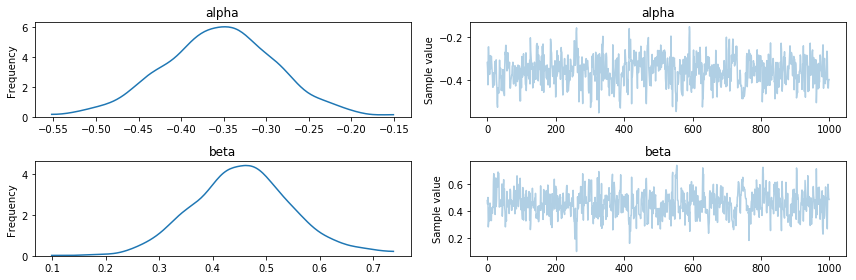

In [101]:
pm.traceplot(trace, ['alpha','beta'])

In [102]:
pm.df_summary(trace, ['alpha','beta'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-0.355992,0.066024,0.003302,-0.482270,-0.220841
beta,0.455265,0.093018,0.004806,0.276677,0.649368


In [103]:
def classify(n, threshold, trace_data):
    n = np.array(n)
    mu = trace_data['alpha'].mean() + trace_data['beta'].mean() * n
    prob = 1 / (1 + np.exp(-mu))
    return prob, prob > threshold

So, we pass in an array with 0 and 1, which means we want to see what the model will predict for Clinton/Trump given just the gender of the voter. As noted above, 0 is Female and 1 is Male, and 0 is Clinton, 1 is Trump.

In [104]:
classify([0,1], 0.5, trace)

(array([ 0.41193024,  0.52479794]), array([False,  True], dtype=bool))

So, I think - if I'm not too tired and haven't made any obtuse or obvious mistakes - this means that a female (the 0 in the array we pass in) has a probability of 0.41 of voting for Trump, and with a threshold - also passed in - of 0.5, she votes for Clinton. A male (1) has a probability of 0.52 of voting for Trump, and with the same threshold he does vote for Trunp.

What's the crosstab - should, perhaps, the proportions match?

In [105]:
pd.crosstab(d_only['sex'], d_only['q10horseGP'], margins=True)

q10horseGP,Clinton/lean Clinton,Trump/lean Trump,All
sex,,,
Female,523,365,888
Male,449,493,942
All,972,858,1830


In [106]:
pd.crosstab(d_only['sex'], d_only['q10horseGP'], normalize='index')

q10horseGP,Clinton/lean Clinton,Trump/lean Trump
sex,,
Female,0.588964,0.411036
Male,0.476645,0.523355


And... I think this confirms that the Bayesian implementation worked!? See the column for Trump - 0.4110 for Female, which matches the output above, and 0.5233 for Male, which also matches.

What about with sklearn?

In [84]:
# X always needs to be a 2-d array, so reshape does this
# (for syntax, try calling without the reshape and see the error)
lr = LogisticRegression().fit(sex_categorical.codes.reshape(-1, 1), y_obs)

In [87]:
lr.predict(np.array([0, 1]).reshape(-1,1))

array([0, 1], dtype=int8)

So, Female has a prediction of Clinton, and Male a prediction of Trump, like we saw before.

What about the probabilities?

In [92]:
lr.predict_proba(np.array([0, 1]).reshape(-1,1))

array([[ 0.58805886,  0.41194114],
       [ 0.47712052,  0.52287948]])

Per http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba, predict_proba gives a row for each row in the input data. Since we pass in 0 and 1, we get a row for 0 (Female) and a row for 1 (Male). The first column is the probability of 0 (Clinton) and the second column is the probability of 1 (Trump). The Bayesian model is predicting the probability of Trump, so we'd expect to see the second column match... and it DOES! Ok. That's awesome, on the first try.

## Add in another variable

In [95]:
racecmb_categorical = pd.Categorical(d_only['racecmb'])
racecmb_categorical

[White, White, White, White, White, ..., White, White, White, White, Or some other race]
Length: 1830
Categories (5, object): [Asian or Asian-American, Black or African-American, Mixed Race, Or some other race, White]

In [123]:
len(np.unique(racecmb_categorical.codes))

5

In [124]:
with pm.Model() as model_with_racecmb:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta_sex = pm.Normal('beta_sex', mu=0, sd=10)
    beta_racecmb = pm.Normal('beta_racecmb', mu=0, sd=10, 
                             shape=len(np.unique(racecmb_categorical.codes)))
    
    mu = alpha + \
         beta_sex * sex_categorical.codes + \
         beta_racecmb[racecmb_categorical.codes] * sex_categorical.codes
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    y = pm.Bernoulli('y', theta, observed=y_obs)

In [125]:
with model_with_racecmb:
    trace_with_racecmb = pm.sample(1000, n_init=50000, tune=1000)
    #trace_with_racecmb = pm.sample(1000, n_init=50000, tune=1000)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [01:40<00:00, 19.82it/s]


In [126]:
varnames_with_racecmb = ['alpha','beta_sex','beta_racecmb']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12e662c18>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1325c1ef0>]], dtype=object)

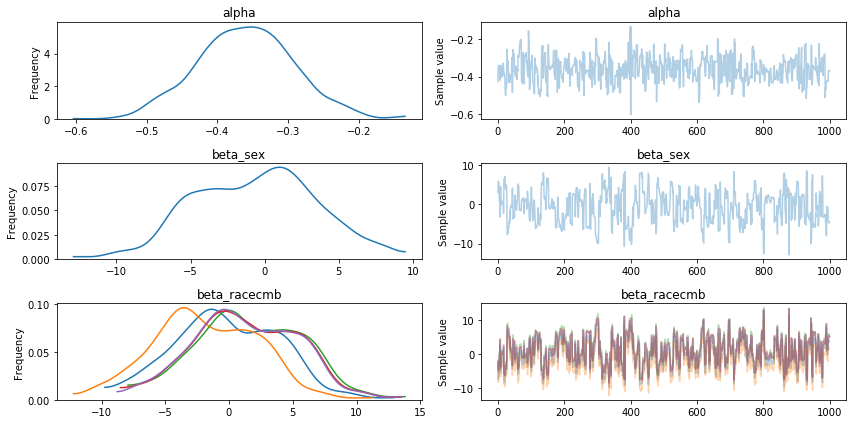

In [127]:
pm.traceplot(trace_with_racecmb, varnames_with_racecmb)

In [128]:
pm.df_summary(trace_with_racecmb, varnames_with_racecmb)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-0.360262,0.067090,0.003299,-0.486927,-0.227217
beta_sex,-0.618728,4.062501,0.270953,-6.951137,8.023335
beta_racecmb__0,-0.141537,4.089663,0.272236,-8.422962,6.569237
beta_racecmb__1,-1.839844,4.059838,0.267968,-10.201952,5.085870
beta_racecmb__2,1.622476,4.089696,0.272453,-7.369271,7.890097
beta_racecmb__3,1.274545,4.063646,0.271575,-7.470081,7.663031
beta_racecmb__4,1.266244,4.056369,0.270869,-7.392074,7.651114


In [140]:
sex_categorical

[Male, Female, Male, Male, Female, ..., Female, Female, Female, Male, Female]
Length: 1830
Categories (2, object): [Female, Male]

In [129]:
racecmb_categorical

[White, White, White, White, White, ..., White, White, White, White, Or some other race]
Length: 1830
Categories (5, object): [Asian or Asian-American, Black or African-American, Mixed Race, Or some other race, White]

In [130]:
with model_with_racecmb:
    trace_with_racecmb = pm.sample(500, n_init=50000, tune=500)
    #trace_with_racecmb = pm.sample(1000, n_init=50000, tune=1000)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:48<00:00, 16.46it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1329f1cc0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x132bae2b0>]], dtype=object)

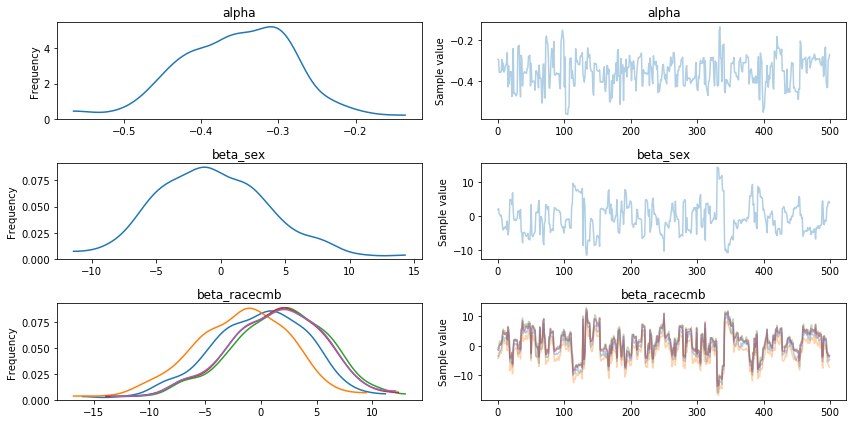

In [131]:
pm.traceplot(trace_with_racecmb, varnames_with_racecmb)

In [132]:
pm.df_summary(trace_with_racecmb, varnames_with_racecmb)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-0.353764,0.072971,0.005060,-0.503764,-0.219328
beta_sex,-0.573645,4.455124,0.372560,-8.693975,8.231394
beta_racecmb__0,-0.208892,4.482532,0.373964,-9.184006,7.677869
beta_racecmb__1,-1.871870,4.479658,0.372446,-10.723462,6.556477
beta_racecmb__2,1.598449,4.472896,0.374165,-7.392703,9.935567
beta_racecmb__3,1.213370,4.457354,0.372660,-7.550354,9.302019
beta_racecmb__4,1.216465,4.452707,0.371975,-7.417473,9.464863


In [142]:
trace_with_racecmb['beta_sex'].mean()

-0.57364481444136439

In [43]:
def standard_logistic(x):
    return 1 / (1 + np.exp(-x))

def classify_with_racecmb(n, threshold, trace_data, varnames):
    n = np.array(n)
    
    mean_vals = pm.df_summary(trace_data, varnames)['mean'].values

    mu = np.dot(n, mean_vals)

    prob = standard_logistic(mu)
    return prob, prob > threshold

In [44]:
a = np.array([1,0,1,0,0,0,0,
              1,1,1,0,0,0,0,
              1,0,0,1,0,0,0,
              1,1,0,1,0,0,0,
              1,0,0,0,1,0,0,              
              1,1,0,0,1,0,0,
              1,0,0,0,0,1,0,
              1,1,0,0,0,1,0,
              1,0,0,0,0,0,1,              
              1,1,0,0,0,0,1,]).reshape(10,-1)
a

array([[1, 0, 1, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0],
       [1, 1, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 0],
       [1, 1, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 1],
       [1, 1, 0, 0, 0, 0, 1]])

In [161]:
classify_with_racecmb(a, 0.5, trace_with_racecmb, varnames_with_racecmb)

(array([ 0.36293326,  0.24300029,  0.09747205,  0.05736316,  0.7763785 ,
         0.6617361 ,  0.70257833,  0.57100708,  0.70322481,  0.57176523]),
 array([False, False, False, False,  True,  True,  True,  True,  True,  True], dtype=bool))

First off, is the classify function correctly doing the math? If we do it manually, do we get the same results? Looks like yes.

In [165]:
# [1, 0, 1, 0, 0, 0, 0]
standard_logistic(-0.353764 + -0.208892)

0.3629331355711774

In [166]:
# [1, 1, 1, 0, 0, 0, 0]
standard_logistic(-0.353764 + -0.573645 + -0.208892)

0.24300014901816597

In [167]:
# [1, 1, 0, 0, 0, 1, 0]
standard_logistic(-0.353764 + -0.573645 + 1.213370)

0.57100703258022611

Still, it seems odd that the coefficient for sex is now negative... i.e., that being a male (1) makes you much more likely to vote for Trump. This is opposite of what I'd have thought, and of what we found in the model previously. It could be because after controlling for race this is what we see - and the model and data are right - or that I've messed up something else.

What do I see if I try it w/ sklearn?

First, I'll use get_dummies to get a matrix - I could instead compose it myself using categoricals and .codes, etc. or w/ custom code, but this seems easiest since it's already written. 

On the same note, I might want to do this way up at the top and use the result instead of the categoricals i've already used above.

Finally, at least for now to match the structure I already have, I want a single column for sex - so can use true for the drop_first arg - and one column per feature for race - and so will use the default false for drop first. I can't do these at the same time, so I'll do them in two separate calls and concatenate the results.

In [46]:
d_only_dummies = pd.concat([pd.get_dummies(d_only['sex'], drop_first=True),
                            pd.get_dummies(d_only['racecmb'])], axis=1)
d_only_dummies.shape

(1830, 6)

In [47]:
d_only_dummies[:2]

,Male,Asian or Asian-American,Black or African-American,Mixed Race,Or some other race,White
0,1,0,0,0,0,1
1,0,0,0,0,0,1


In [52]:
lr = LogisticRegression().fit(d_only_dummies.values, y_obs)

In [53]:
lr.predict(a[:,1:]) # use slices/indexing to get rid of the first col w/ 1s for the alpha intercept

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1], dtype=int8)

In [54]:
lr.predict_proba(a[:,1:])

array([[ 0.82390962,  0.17609038],
       [ 0.74815752,  0.25184248],
       [ 0.96154435,  0.03845565],
       [ 0.94074273,  0.05925727],
       [ 0.5458355 ,  0.4541645 ],
       [ 0.43280998,  0.56719002],
       [ 0.63804806,  0.36195194],
       [ 0.52813236,  0.47186764],
       [ 0.53230074,  0.46769926],
       [ 0.4194892 ,  0.5805108 ]])

Again, the above is a row per input, with the first col showing the probability of Clinton and the second the probability of Trump. So, the second column should roughly match the Bayesian model's output, I think (like it did previously).

In [55]:
lr.coef_

array([[ 0.45425376, -0.60268981, -2.27866138,  0.75651549,  0.37347149,
         0.81099053]])

In [56]:
lr.intercept_

array([-0.94037367])

So, the intercept's definitely different. The beta values are too. The first value, which is on when the voter is male, is 0.45, which is positive (like we'd expect) and - fwiw, I don't think I would always expect this to be the case, because I think adding other predictors could change it - also is the same as it was w/ the original model.

The race coefficients are negative for Asians, very negative for African Americans, and positive for mixed race, other, and, most so, for white.

So, the sklearn model makes sense. The Bayesian model doesn't, and it doesn't match the sklearn model.

## Another try w/ race, this time with the data from get_dummies

In [57]:
d_only_dummies.values.shape[1]

6

In [58]:
with pm.Model() as model_with_racecmb_2:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=d_only_dummies.values.shape[1])
    
    mu = alpha + pm.math.dot(d_only_dummies.values, beta)
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    y = pm.Bernoulli('y', theta, observed=y_obs)

In [59]:
with model_with_racecmb_2:
    trace_with_racecmb_2 = pm.sample(1000, n_init=50000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [02:16<00:00, 14.65it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e399518>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11e4c4550>]], dtype=object)

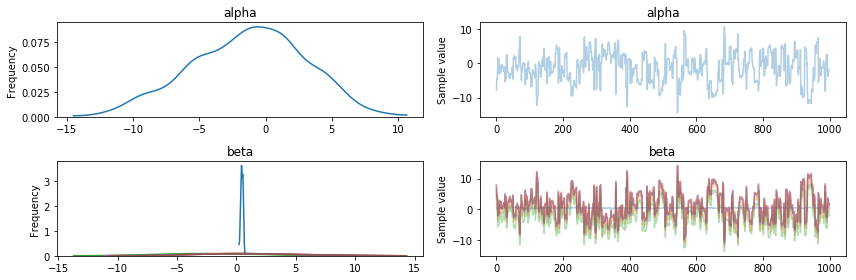

In [60]:
pm.traceplot(trace_with_racecmb_2, ['alpha','beta'])

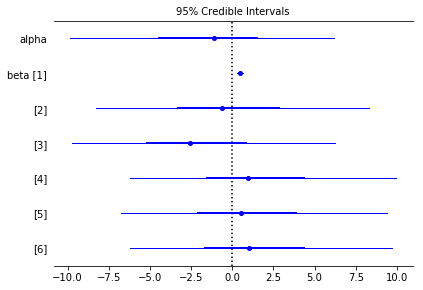

In [61]:
pm.forestplot(trace_with_racecmb_2, ['alpha','beta'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e5d35f8>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x119113ac8>]], dtype=object)

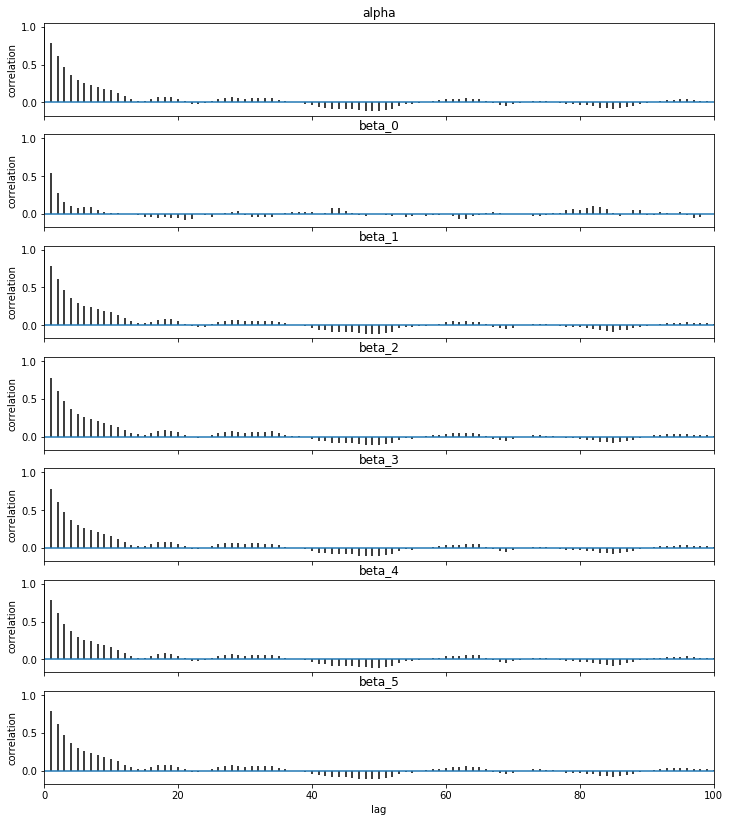

In [62]:
pm.autocorrplot(trace_with_racecmb_2, ['alpha','beta'])

In [63]:
pm.df_summary(trace_with_racecmb_2, ['alpha', 'beta'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-1.363039,4.287351,0.304978,-9.844583,6.159840
beta__0,0.467691,0.098848,0.005140,0.293454,0.665360
beta__1,-0.377629,4.327602,0.307066,-8.277495,8.294961
beta__2,-2.250797,4.307413,0.305978,-9.755059,6.260822
beta__3,1.254859,4.277718,0.303277,-6.197374,9.956638
beta__4,0.791883,4.279635,0.304189,-6.733908,9.383596
beta__5,1.228189,4.283674,0.304994,-6.238690,9.709869


In [65]:
a

array([[1, 0, 1, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0],
       [1, 1, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 0],
       [1, 1, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 1],
       [1, 1, 0, 0, 0, 0, 1]])

In [64]:
classify_with_racecmb(a, 0.5, trace_with_racecmb_2, ['alpha','beta'])

(array([ 0.149228  ,  0.21874788,  0.0262411 ,  0.0412434 ,  0.47298113,
         0.58892179,  0.36097011,  0.47415672,  0.46633847,  0.58245039]),
 array([False, False, False, False, False,  True, False, False, False,  True], dtype=bool))

In [68]:
pm.df_summary(trace_with_racecmb_2, ['alpha','beta'])['mean'].values

array([-1.36303942,  0.46769075, -0.37762942, -2.25079736,  1.25485858,
        0.79188337,  1.22818934])

In [69]:
standard_logistic(-1.363 + -0.3776)

0.14923673941624671

Ok, that appears to work. The forest plot and the summary means are what we'd expect and, sometimes more and sometimes less, match the LR coefs... sometimes they're very close (sex) and when they're not close they're the right sign and in the right neighborhood.

# Try a first hierarchical model

Now I want to try a hierarchical model where the race features share a common hyperprior.

In [70]:
with pm.Model() as model_with_racecmb_multilevel:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    
    mu_beta = pm.Normal('mu_beta', mu=0, sd=10)
    sigma_beta = pm.HalfCauchy('sigma_beta', 5)
    beta = pm.Normal('beta', mu=mu_beta, sd=sigma_beta, shape=d_only_dummies.values.shape[1])
    
    mu = alpha + pm.math.dot(d_only_dummies.values, beta)
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    y = pm.Bernoulli('y', theta, observed=y_obs)

In [71]:
with model_with_racecmb_multilevel:
    trace_with_racecmb_multilevel = pm.sample(1000, n_init=50000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [01:43<00:00, 16.41it/s]


In [78]:
varnames_racecmb_multilevel = ['alpha', 'beta', 'mu_beta', 'sigma_beta']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121c33438>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x123f93a58>]], dtype=object)

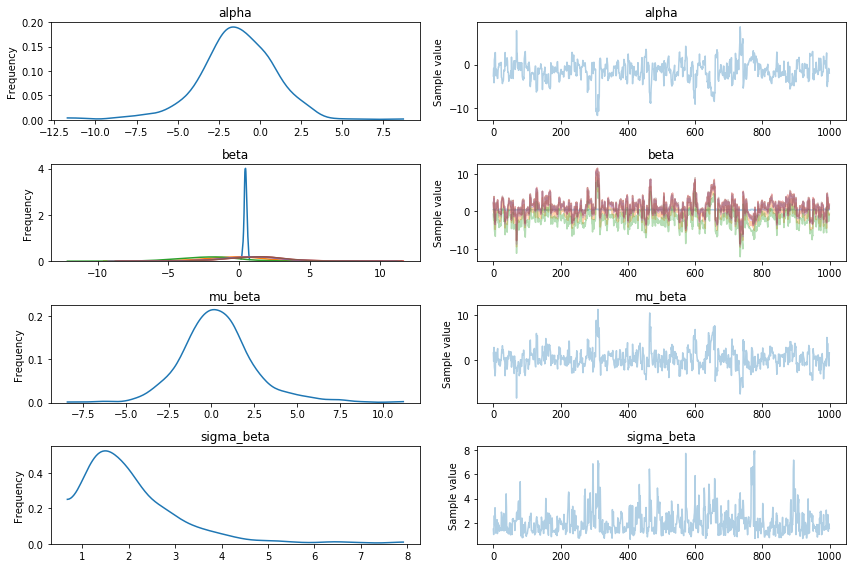

In [79]:
pm.traceplot(trace_with_racecmb_multilevel, varnames_racecmb_multilevel)

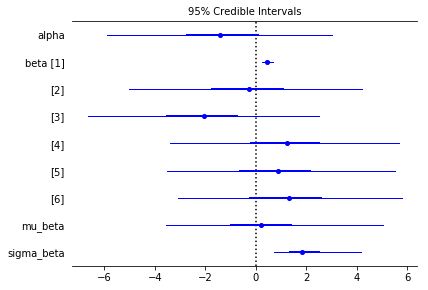

In [80]:
pm.forestplot(trace_with_racecmb_multilevel, varnames_racecmb_multilevel)

In [81]:
pm.df_summary(trace_with_racecmb_multilevel, varnames_racecmb_multilevel)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-1.453264,2.367619,0.160674,-5.909131,3.038537
beta__0,0.459711,0.099166,0.003934,0.266068,0.666534
beta__1,-0.216354,2.393958,0.158395,-5.043023,4.197393
beta__2,-2.054869,2.392133,0.161199,-6.672612,2.515041
beta__3,1.288314,2.370956,0.159890,-3.418206,5.695112
beta__4,0.881706,2.365928,0.159704,-3.508258,5.505023
beta__5,1.324260,2.364713,0.160113,-3.084158,5.789184
mu_beta,0.333713,2.151189,0.142316,-3.575873,5.055055
sigma_beta,2.103566,1.090049,0.068799,0.741233,4.163000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124305940>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x12467a9b0>]], dtype=object)

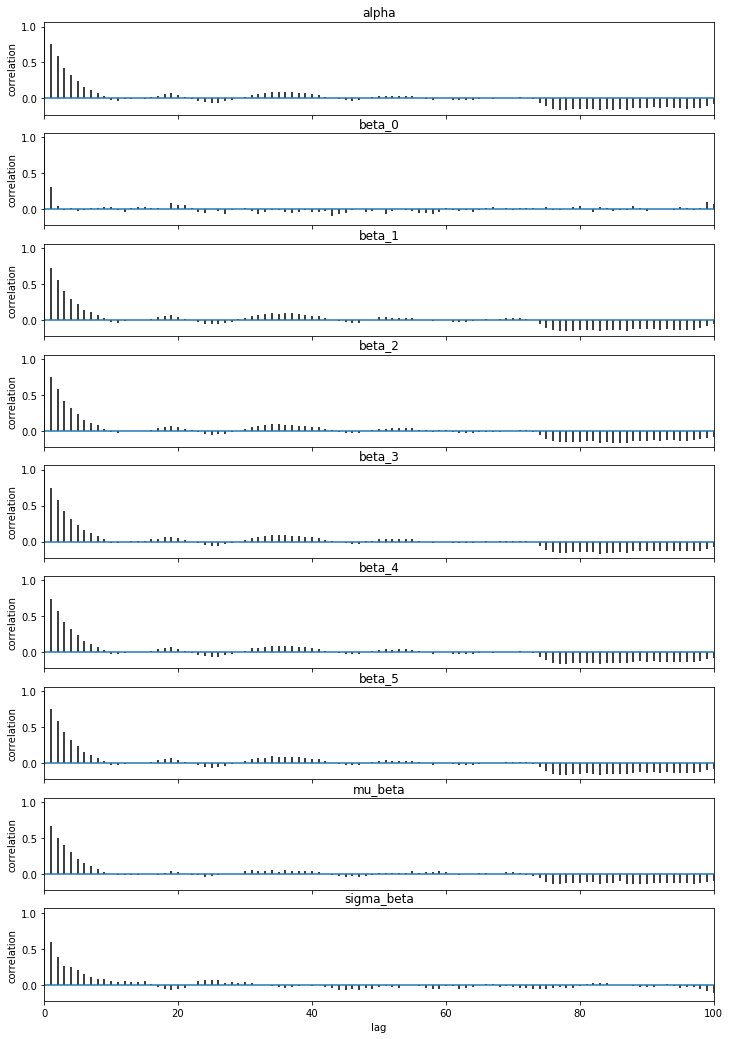

In [82]:
pm.autocorrplot(trace_with_racecmb_multilevel, varnames_racecmb_multilevel)

In [86]:
varnames_racecmb_multilevel[:2]

['alpha', 'beta']

In [88]:
classify_with_racecmb(a, 0.5, trace_with_racecmb_multilevel, 
                      varnames_racecmb_multilevel[:2])
# [:2] to filter off the hyperparams and leave just alpha and beta

(array([ 0.15847514,  0.22971762,  0.02908171,  0.04528568,  0.45885582,
         0.5731615 ,  0.3608775 ,  0.47206759,  0.46779366,  0.58193152]),
 array([False, False, False, False, False,  True, False, False, False,  True], dtype=bool))

I eyeballed the forest plots, means, and output of classify comparing the non-hierarchical model and the hierarchical model and see that the results are relatively close. Looking at the classified examples, I do see that many of the observations are bumped toward the middle from a more extreme (for ex, lower) value. 

However, I think my model's wrong. As above, I'm sharing a single set of mu and sigma hyperparameters among ALL beta params, which means I'm sharing the same my between sex and each individual race param. I don't want to do this - instead, I want a normal param for sex, and shared hyperparams for just the race features. What's the best way to do this, hopefully keeping the matrix of values.

In [89]:
vals = d_only_dummies.values
vals.shape

(1830, 6)

In [93]:
vals[:10]

array([[1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]], dtype=uint8)

In [95]:
vals[:,1:][:10]

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]], dtype=uint8)

In [124]:
with pm.Model() as model_with_racecmb_multilevel_2:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta_sex = pm.Normal('beta_sex', mu=0, sd=10)
    
    mu_race = pm.Normal('mu_race', mu=0, sd=10)
    sigma_race = pm.HalfCauchy('sigma_race', 5)
    beta_race = pm.Normal('beta_race', mu=mu_race, sd=sigma_race, shape=5)
    
    mu = alpha + \
         vals[:,0] * beta_sex + \
         pm.math.dot(vals[:,1:], beta_race)
            
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    y = pm.Bernoulli('y', theta, observed=y_obs)

In [125]:
with model_with_racecmb_multilevel_2:
    trace_with_racecmb_multilevel_2 = pm.sample(1000, n_init=50000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [05:02<00:00,  6.75it/s]/Users/andrewenfield/miniconda3/envs/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)



In [128]:
varnames_racecmb_multilevel_2 = ['alpha', 'beta_sex', 'beta_race',
                                 'mu_race', 'sigma_race']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x128c6af98>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x127340390>]], dtype=object)

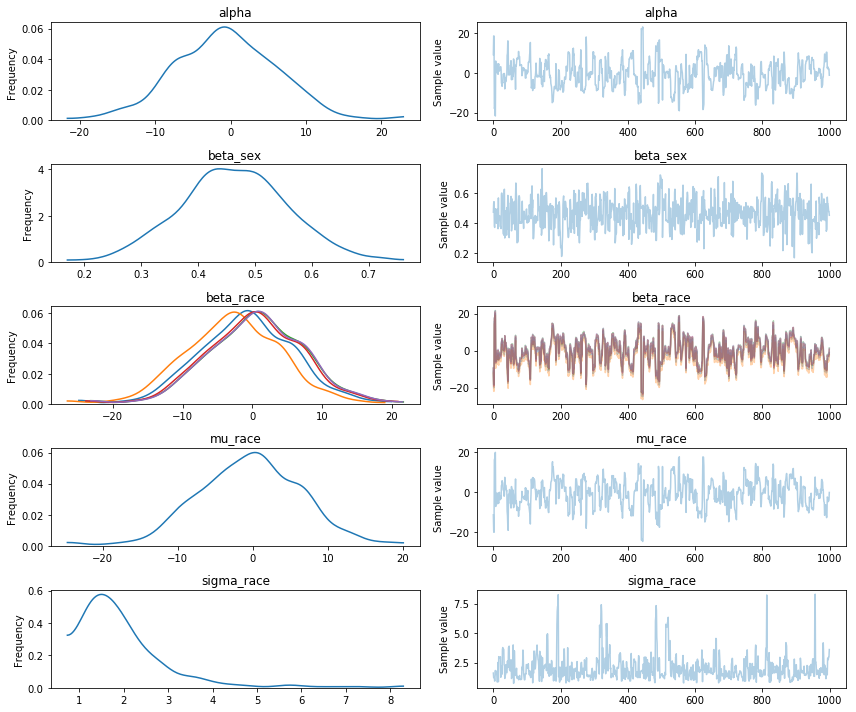

In [129]:
pm.traceplot(trace_with_racecmb_multilevel_2, 
             varnames_racecmb_multilevel_2)

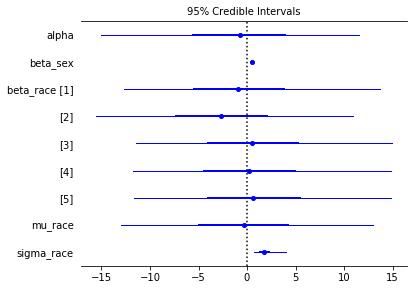

In [130]:
pm.forestplot(trace_with_racecmb_multilevel_2, 
             varnames_racecmb_multilevel_2)

In [131]:
pm.df_summary(trace_with_racecmb_multilevel_2, 
             varnames_racecmb_multilevel_2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-0.658035,6.850533,0.468724,-15.071133,11.518379
beta_sex,0.463908,0.095547,0.004108,0.257737,0.633377
beta_race__0,-1.007240,6.863921,0.468782,-12.711081,13.686558
beta_race__1,-2.839859,6.862659,0.468975,-15.600990,10.925062
beta_race__2,0.502196,6.846793,0.467940,-11.436247,14.957250
beta_race__3,0.077906,6.857356,0.468791,-11.728114,14.812777
beta_race__4,0.525331,6.845651,0.468027,-11.694621,14.872888
mu_race,-0.525823,6.839452,0.462930,-13.030376,12.962774
sigma_race,2.021250,1.079382,0.064063,0.759571,3.984406


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124f6de10>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x12926f390>]], dtype=object)

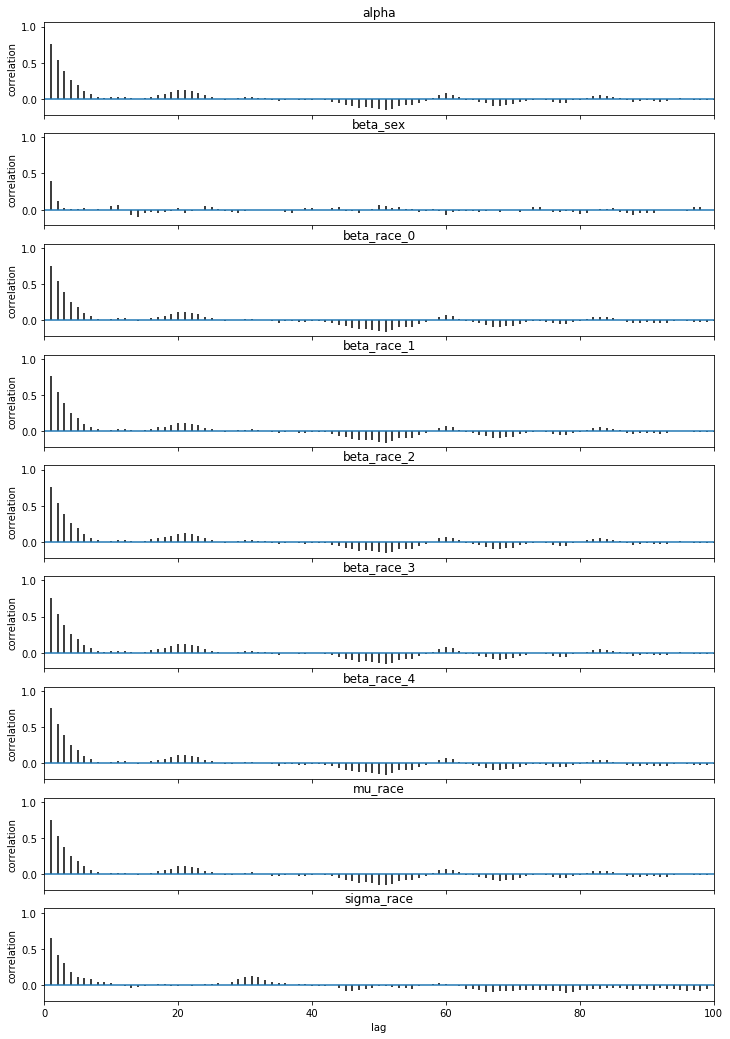

In [132]:
pm.autocorrplot(trace_with_racecmb_multilevel_2, 
             varnames_racecmb_multilevel_2)

In [134]:
varnames_racecmb_multilevel_2

['alpha', 'beta_sex', 'beta_race', 'mu_race', 'sigma_race']

In [135]:
pm.df_summary(trace_with_racecmb_multilevel_2,
              varnames_racecmb_multilevel_2[:3])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-0.658035,6.850533,0.468724,-15.071133,11.518379
beta_sex,0.463908,0.095547,0.004108,0.257737,0.633377
beta_race__0,-1.007240,6.863921,0.468782,-12.711081,13.686558
beta_race__1,-2.839859,6.862659,0.468975,-15.600990,10.925062
beta_race__2,0.502196,6.846793,0.467940,-11.436247,14.957250
beta_race__3,0.077906,6.857356,0.468791,-11.728114,14.812777
beta_race__4,0.525331,6.845651,0.468027,-11.694621,14.872888


In [136]:
classify_with_racecmb(a, 0.5, trace_with_racecmb_multilevel_2, 
                      varnames_racecmb_multilevel_2[:3])

(array([ 0.15905516,  0.23123215,  0.02937222,  0.04591391,  0.46111882,
         0.57641381,  0.35890295,  0.47097749,  0.4668725 ,  0.58205224]),
 array([False, False, False, False, False,  True, False, False, False,  True], dtype=bool))

Ok, so, comparing the above to the non-hierarchical model, I still see what I think are the probabilities shrunk more toward the mean for all of the race values, except for the 'White' value, which stays pretty much the same (only changes in the third decimal place and then only slightly). The others change more, which I think is what we'd expect, given the proportions - shown below - of each of the other race values. 

Note also that now the mean values for the race coefs, as reported by df_summary, are a lot lower than they were before - in fact all below zero, right? However, the relationship between each of them is still the same. And, the alpha coef is a lot higher - moving from below -1 to almost zero. And the predictions stay pretty much the same. I think it's likely the alpha moving up that compensates for the beta values moving down.

In [137]:
d_only['racecmb'].value_counts(dropna=False)

White                        1481
Black or African-American     172
Or some other race             98
Mixed Race                     44
Asian or Asian-American        35
Name: racecmb, dtype: int64

# Add in the states

Now that we have a structure that seems to work hierarchically, all the way through to prediction, I'll try to add in the state data.

In [138]:
len(np.unique(d_only['state']))

50

In [139]:
d_only['state'].value_counts(dropna=False)

California              158
Texas                   133
Florida                 123
New York                121
Pennsylvania             75
Ohio                     72
New Jersey               68
Georgia                  62
North Carolina           61
Michigan                 61
Virginia                 60
Illinois                 57
Minnesota                48
Washington               45
Arizona                  45
Wisconsin                43
Tennessee                37
Missouri                 34
Kentucky                 34
South Carolina           33
Colorado                 33
Indiana                  33
Maryland                 30
Oregon                   29
Louisiana                28
Massachusetts            28
Oklahoma                 26
Alabama                  22
Iowa                     19
Kansas                   19
Idaho                    18
Nevada                   18
Connecticut              17
Utah                     15
West Virginia            15
Mississippi         

We'll see these states below having extremes, which makes sense given that they're small sample sizes and all or almost all for a single candidate. Ideally, we should shrinkage especially w/ these states. In addition, as noted above, we don't have any rows at all for South Dakota, so we should expect that state to be the average, I think. (Note that we don't have SD at all in the first cut at the dummied data because it didn't exist, we have to go back and add it manually.)

In [242]:
d_only[d_only['state'] == 'Montana']['q10horse']

328    Trump/lean Trump
Name: q10horse, dtype: object

In [241]:
d_only[d_only['state'] == 'North Dakota']['q10horse']

1089    Trump/lean Trump
1647    Trump/lean Trump
1664    Trump/lean Trump
2010    Trump/lean Trump
2175    Trump/lean Trump
2310    Trump/lean Trump
2370    Trump/lean Trump
Name: q10horse, dtype: object

In [243]:
d_only[d_only['state'] == 'District of Columbia']['q10horse']

37      Clinton/lean Clinton
282     Clinton/lean Clinton
415     Clinton/lean Clinton
705     Clinton/lean Clinton
852     Clinton/lean Clinton
1035    Clinton/lean Clinton
1053    Clinton/lean Clinton
1162        Trump/lean Trump
2131    Clinton/lean Clinton
2237    Clinton/lean Clinton
2475    Clinton/lean Clinton
Name: q10horse, dtype: object

We don't have any rows in our two-party data w/ South Dakota, so absent any extra work on our part, we won't have a dummy indicator variable for SD, which'll make it harder to do stuff w/ the state later. We'll add it here when we're forming the dummies w/ states.

In [315]:
# add South Dakota, using the same index to make sure we don't extra cols (prob a better way to do this)
state_dummies = pd.concat([pd.get_dummies(d_only['state']), 
                           pd.Series(name='South Dakota', data=np.repeat(0, len(d_only)), index=d_only.index)], axis=1)
# alphabetize to put SD in the right spot
state_dummies = state_dummies.reindex(sorted(state_dummies.columns), axis=1)
state_dummies.shape

(1830, 51)

And keep the number of states for easy use later.

In [332]:
state_count = len(state_dummies.columns.values)
state_count

51

In [316]:
d_only_dummies_with_state = pd.concat([pd.get_dummies(d_only['sex'], drop_first=True),
                                       pd.get_dummies(d_only['racecmb']),
                                       state_dummies], axis=1)
d_only_dummies_with_state.shape

(1830, 57)

In [317]:
d_only_dummies_with_state[:2]

,Male,Asian or Asian-American,Black or African-American,Mixed Race,Or some other race,White,Alabama,Alaska,Arizona,Arkansas,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [318]:
vals_with_state = d_only_dummies_with_state.values
vals_with_state.shape

(1830, 57)

In [319]:
vals_with_state[:,1:6].shape, vals_with_state[:,6:].shape

((1830, 5), (1830, 51))

In [155]:
with pm.Model() as model_with_race_and_state:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta_sex = pm.Normal('beta_sex', mu=0, sd=10)
    
    mu_race = pm.Normal('mu_race', mu=0, sd=10)
    sigma_race = pm.HalfCauchy('sigma_race', 5)
    beta_race = pm.Normal('beta_race', mu=mu_race, sd=sigma_race, 
                          shape=len(np.unique(d_only['racecmb'])))
    
    mu_state = pm.Normal('mu_state', mu=0, sd=10)
    sigma_state = pm.HalfCauchy('sigma_state', 5)
    beta_state = pm.Normal('beta_state', mu=mu_state, sd=sigma_state, 
                           shape=state_count)
    
    # would be good to not hardcode the indices - could generalize
    # using the same code to pull out the shapes using unique above
    mu = alpha + \
         vals_with_state[:,0] * beta_sex + \
         pm.math.dot(vals_with_state[:,1:6], beta_race) + \
         pm.math.dot(vals_with_state[:,6:], beta_state)
            
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    y = pm.Bernoulli('y', theta, observed=y_obs)

In [166]:
with model_with_race_and_state:
    trace_with_race_and_state = pm.sample(10000, n_init=50000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 11000/11000 [50:34<00:00,  4.76it/s] /Users/andrewenfield/miniconda3/envs/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)



I originally tried this w/ the 1k steps but the chain didn't look good for any of the steps. So I tried w/ 10k steps, and it _still_ looks horrible. Something's going on. With 10k steps, it took 50m to run, so I persisted the model and trace via pickle below.

In [174]:
with open('trace_with_race_and_state.pkl', 'wb') as buff:
    pickle.dump({'model': model_with_race_and_state, 'trace': trace_with_race_and_state}, buff)

In [168]:
varnames_race_and_state = ['alpha', 'beta_sex', 'beta_race', 
                           'beta_state', 'mu_race', 'sigma_race', 
                           'mu_state', 'sigma_state']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13d9d7828>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13dfac630>]], dtype=object)

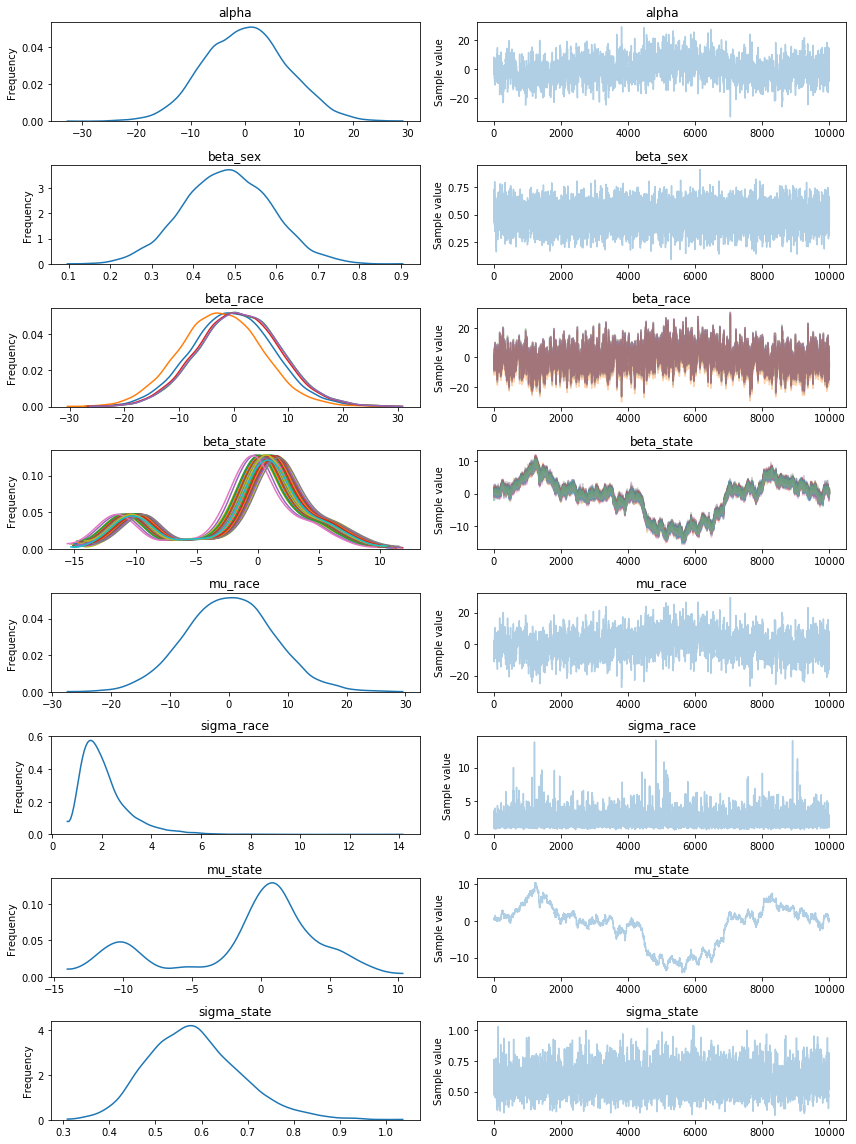

In [169]:
pm.traceplot(trace_with_race_and_state, varnames_race_and_state)

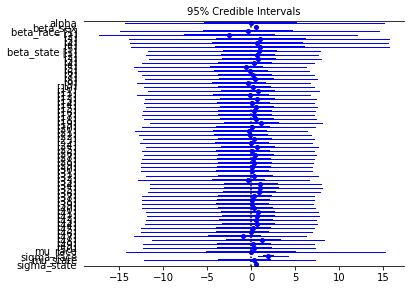

In [170]:
pm.forestplot(trace_with_race_and_state, varnames_race_and_state)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13f5fb0f0>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x11e6f4240>]], dtype=object)

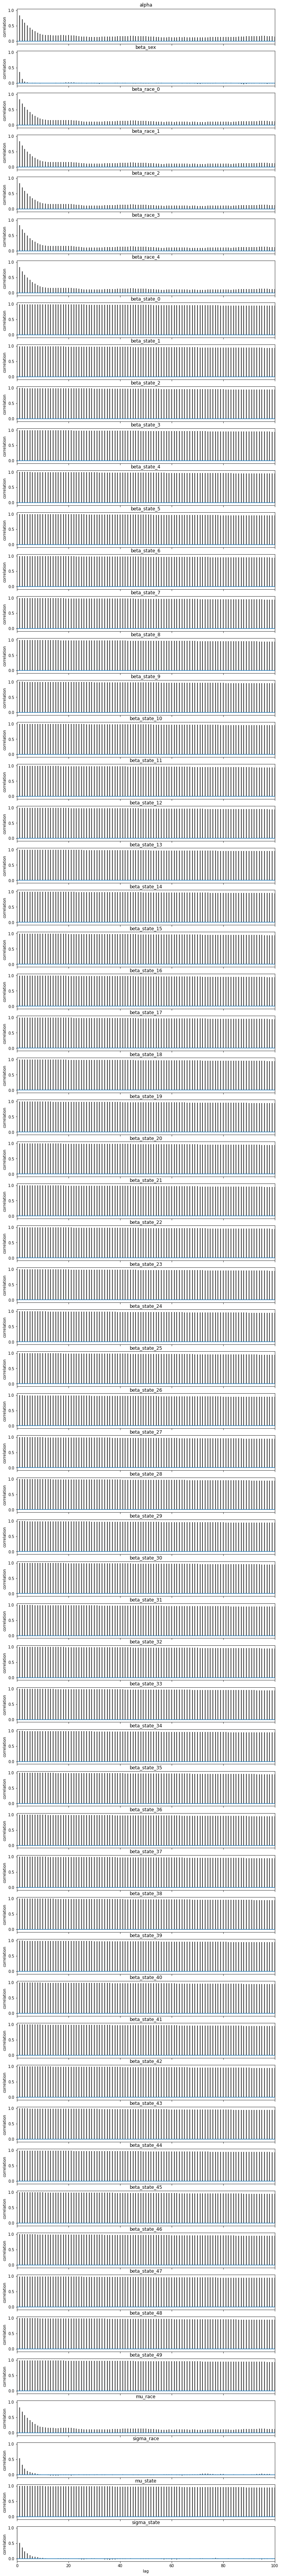

In [171]:
pm.autocorrplot(trace_with_race_and_state, varnames_race_and_state)

In [172]:
pm.df_summary(trace_with_race_and_state, varnames_race_and_state)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,0.061857,7.646555,0.362876,-14.351806,15.063494
beta_sex,0.479307,0.104127,0.001488,0.264148,0.671387
beta_race__0,-0.359579,7.510216,0.335464,-14.976414,14.456505
beta_race__1,-2.499879,7.507838,0.335430,-17.342061,11.997144
beta_race__2,1.080883,7.499488,0.335326,-13.874742,15.601696
beta_race__3,0.670592,7.500905,0.335134,-13.825917,15.509196
beta_race__4,1.029304,7.497373,0.335445,-13.651871,15.675364
beta_state__0,-0.530303,5.488250,0.543162,-11.748624,7.743009
beta_state__1,-0.833409,5.484531,0.541846,-12.012611,7.549609
beta_state__2,-0.638886,5.477809,0.542620,-11.618144,7.860610


Try without hierarchy, just to see what happens?

In [175]:
with pm.Model() as model_with_race_and_state_2:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta_sex = pm.Normal('beta_sex', mu=0, sd=10)
    
    mu_race = pm.Normal('mu_race', mu=0, sd=10)
    sigma_race = pm.HalfCauchy('sigma_race', 5)
    beta_race = pm.Normal('beta_race', mu=mu_race, sd=sigma_race, 
                          shape=len(np.unique(d_only['racecmb'])))
    
    #mu_state = pm.Normal('mu_state', mu=0, sd=10)
    #sigma_state = pm.HalfCauchy('sigma_state', 5)
    #beta_state = pm.Normal('beta_state', mu=mu_state, sd=sigma_state, 
    #                       shape=len(np.unique(d_only['state'])))
    beta_state = pm.Normal('beta_state', mu=0, sd=10, 
                           shape=state_count)

    # would be good to not hardcode the indices - could generalize
    # using the same code to pull out the shapes using unique above
    mu = alpha + \
         vals_with_state[:,0] * beta_sex + \
         pm.math.dot(vals_with_state[:,1:6], beta_race) + \
         pm.math.dot(vals_with_state[:,6:], beta_state)
            
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    y = pm.Bernoulli('y', theta, observed=y_obs)

In [176]:
with model_with_race_and_state_2:
    trace_with_race_and_state_2 = pm.sample(1000, n_init=50000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [09:40<00:00,  3.23it/s]/Users/andrewenfield/miniconda3/envs/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)



In [177]:
varnames_race_and_state_2 = ['alpha', 'beta_sex', 'beta_race', 
                           'beta_state', 'mu_race', 'sigma_race']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ea87c18>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x133423240>]], dtype=object)

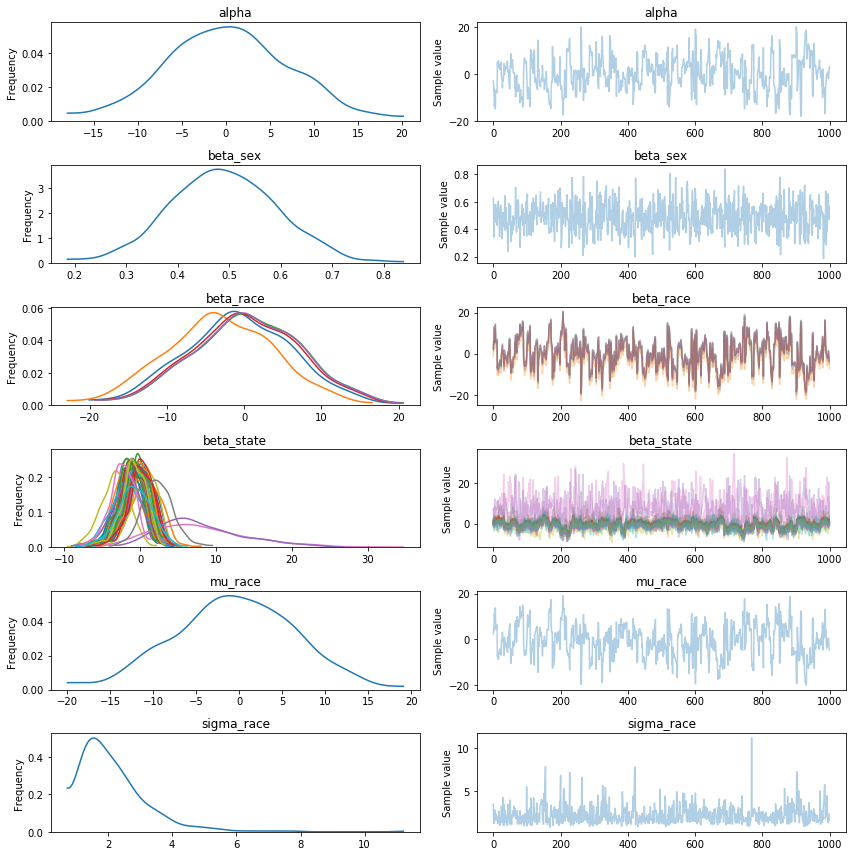

In [178]:
pm.traceplot(trace_with_race_and_state_2, varnames_race_and_state_2)

In [179]:
pm.df_summary(trace_with_race_and_state_2, varnames_race_and_state_2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,0.250274,6.923660,0.472089,-14.228616,12.598869
beta_sex,0.488168,0.103133,0.003772,0.286599,0.683932
beta_race__0,-0.911233,6.969685,0.493055,-15.035014,12.156363
beta_race__1,-3.223442,6.969572,0.493820,-17.095570,9.842322
beta_race__2,0.500130,6.970678,0.491963,-13.270086,13.875349
beta_race__3,0.045816,6.954065,0.491619,-13.684856,13.587767
beta_race__4,0.433085,6.958570,0.492062,-13.926317,13.288868
beta_state__0,0.394685,1.683318,0.136990,-2.809246,3.560620
beta_state__1,0.808697,2.036124,0.145602,-3.563892,4.212767
beta_state__2,-0.071970,1.612492,0.134367,-3.096222,3.120591


In [320]:
d_only_dummies_with_state.iloc[0]

Male                         1
Asian or Asian-American      0
Black or African-American    0
Mixed Race                   0
Or some other race           0
White                        1
Alabama                      0
Alaska                       0
Arizona                      0
Arkansas                     0
California                   0
Colorado                     0
Connecticut                  0
Delaware                     0
District of Columbia         0
Florida                      0
Georgia                      0
Hawaii                       0
Idaho                        0
Illinois                     0
Indiana                      0
Iowa                         0
Kansas                       0
Kentucky                     0
Louisiana                    0
Maine                        0
Maryland                     0
Massachusetts                0
Michigan                     0
Minnesota                    1
Mississippi                  0
Missouri                     0
Montana 

A quick dict to map row numbers to state names.

In [325]:
state_number_to_name = dict(list(zip(range(0,51), sorted(state_dummies.columns.values))))
state_number_to_name

{0: 'Alabama',
 1: 'Alaska',
 2: 'Arizona',
 3: 'Arkansas',
 4: 'California',
 5: 'Colorado',
 6: 'Connecticut',
 7: 'Delaware',
 8: 'District of Columbia',
 9: 'Florida',
 10: 'Georgia',
 11: 'Hawaii',
 12: 'Idaho',
 13: 'Illinois',
 14: 'Indiana',
 15: 'Iowa',
 16: 'Kansas',
 17: 'Kentucky',
 18: 'Louisiana',
 19: 'Maine',
 20: 'Maryland',
 21: 'Massachusetts',
 22: 'Michigan',
 23: 'Minnesota',
 24: 'Mississippi',
 25: 'Missouri',
 26: 'Montana',
 27: 'Nebraska',
 28: 'Nevada',
 29: 'New Hampshire',
 30: 'New Jersey',
 31: 'New Mexico',
 32: 'New York',
 33: 'North Carolina',
 34: 'North Dakota',
 35: 'Ohio',
 36: 'Oklahoma',
 37: 'Oregon',
 38: 'Pennsylvania',
 39: 'Rhode Island',
 40: 'South Carolina',
 41: 'South Dakota',
 42: 'Tennessee',
 43: 'Texas',
 44: 'Utah',
 45: 'Vermont',
 46: 'Virginia',
 47: 'Washington',
 48: 'West Virginia',
 49: 'Wisconsin',
 50: 'Wyoming'}

A few states, with low and high mean values, per above.

In [326]:
# offset for the fields in the summary that aren't states
state_field_offset = 7

In [379]:
state_ids = [8, 26, 34, 41]
state_ids_with_offset = [id+state_field_offset for id in state_ids]
state_ids_with_offset

[15, 33, 41, 48]

In [380]:
pm.df_summary(trace_with_race_and_state_2, varnames_race_and_state_2)['mean'].iloc[state_ids_with_offset]

beta_state__8    -3.317866
beta_state__26    7.893734
beta_state__34    8.069842
beta_state__41   -0.160178
Name: mean, dtype: float64

In [329]:
[state_number_to_name[id] for id in state_ids]

['District of Columbia', 'Montana', 'North Dakota']

In [199]:
with pm.Model() as model_with_race_and_state_3:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta_sex = pm.Normal('beta_sex', mu=0, sd=10)
    
    mu_race = pm.Normal('mu_race', mu=0, sd=10)
    sigma_race = pm.HalfCauchy('sigma_race', 5)
    beta_race = pm.Normal('beta_race', mu=mu_race, sd=sigma_race, 
                          shape=len(np.unique(d_only['racecmb'])))
    
    mu_state = pm.Normal('mu_state', mu=0, sd=10)
    #sigma_state = pm.HalfCauchy('sigma_state', 5)
    beta_state = pm.Normal('beta_state', mu=mu_state, sd=10, 
                          shape=state_count)
#     beta_state = pm.Normal('beta_state', mu=0, sd=10, 
#                            shape=len(np.unique(d_only['state'])))

    # would be good to not hardcode the indices - could generalize
    # using the same code to pull out the shapes using unique above
    mu = alpha + \
         vals_with_state[:,0] * beta_sex + \
         pm.math.dot(vals_with_state[:,1:6], beta_race) + \
         pm.math.dot(vals_with_state[:,6:], beta_state)
            
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    y = pm.Bernoulli('y', theta, observed=y_obs)

In [200]:
with model_with_race_and_state_3:
    trace_with_race_and_state_3 = pm.sample(1000, n_init=50000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [11:41<00:00,  1.43it/s]/Users/andrewenfield/miniconda3/envs/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)



In [201]:
varnames_race_and_state_3 = ['alpha', 'beta_sex', 'beta_race', 
                           'beta_state', 'mu_race', 'sigma_race', 
                           'mu_state']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14294ae80>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x142df5b38>]], dtype=object)

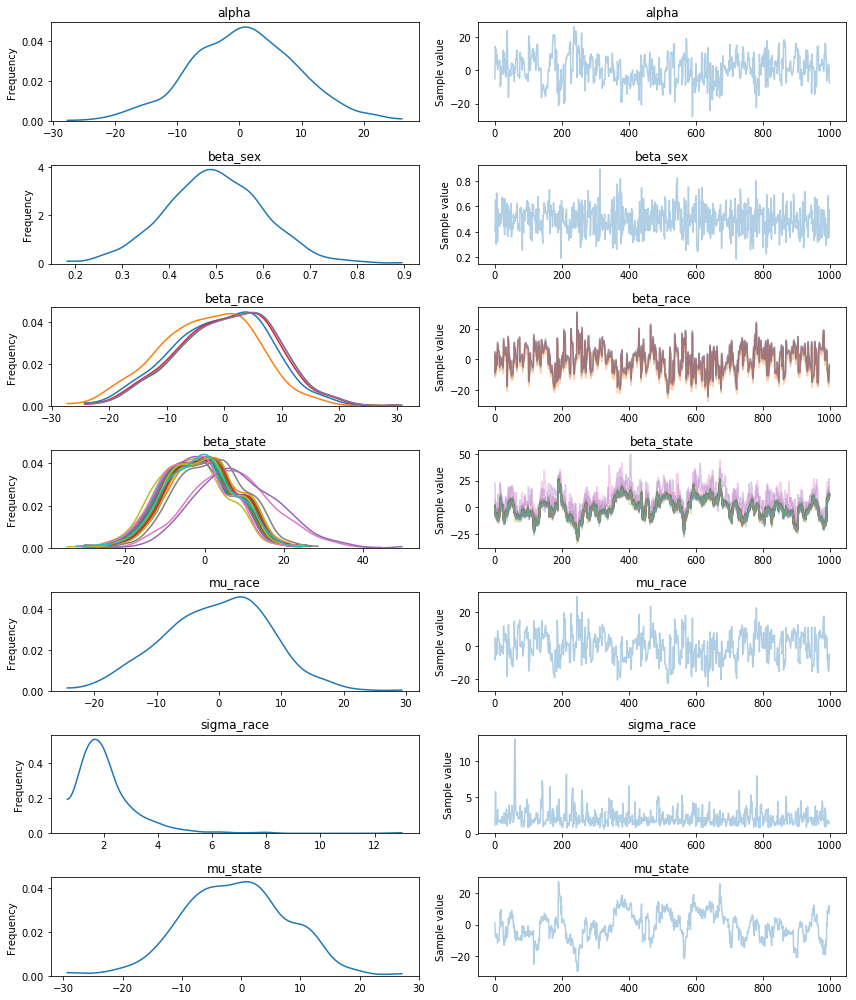

In [202]:
pm.traceplot(trace_with_race_and_state_3, varnames_race_and_state_3)

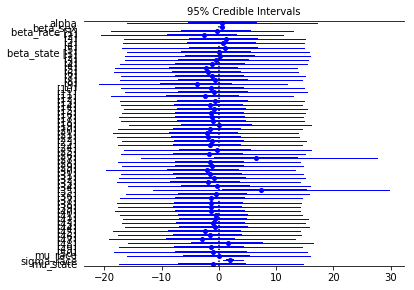

In [203]:
pm.forestplot(trace_with_race_and_state_3, varnames_race_and_state_3)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1320bda58>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x145f344a8>]], dtype=object)

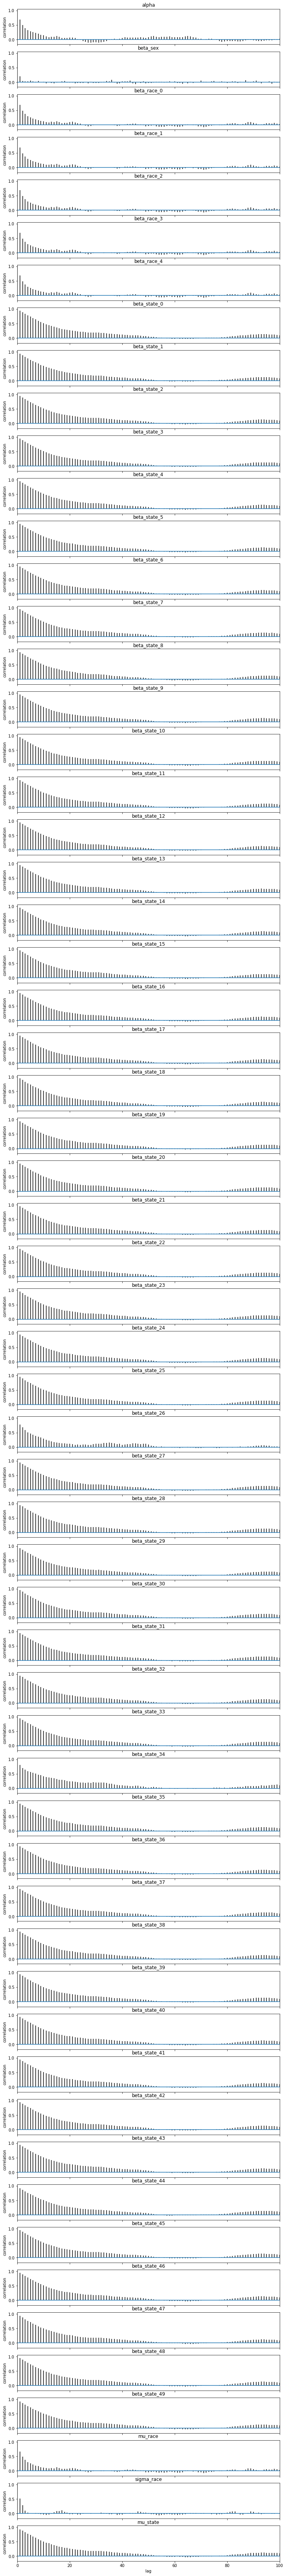

In [204]:
pm.autocorrplot(trace_with_race_and_state_3, varnames_race_and_state_3)

In [205]:
pm.df_summary(trace_with_race_and_state_3, varnames_race_and_state_3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,0.683708,8.443116,0.600960,-16.036517,17.108507
beta_sex,0.494444,0.103299,0.003942,0.287027,0.692631
beta_race__0,-0.746945,8.312636,0.549448,-18.881736,12.930667
beta_race__1,-3.058086,8.312248,0.548627,-20.634789,11.251826
beta_race__2,0.663504,8.282941,0.547402,-16.556704,15.016930
beta_race__3,0.221893,8.306469,0.548519,-16.827493,14.827611
beta_race__4,0.590292,8.297993,0.548504,-16.850691,14.794315
beta_state__0,-0.185325,8.768531,0.804441,-16.094388,15.703368
beta_state__1,0.256877,8.821414,0.801928,-16.420134,15.962072
beta_state__2,-0.665841,8.782343,0.806445,-16.392344,15.551651


Ok, so it looks like the weird outliers - the separate lines for state - above are North Dakota and Montana, which are states 34 and 26.

In [209]:
d_only_dummies_with_state.iloc[0].index[26 + 6], d_only_dummies_with_state.iloc[0].index[34 + 6]

('Montana', 'North Dakota')

In [214]:
pm.df_summary(trace_with_race_and_state_3, varnames_race_and_state_3).iloc[[24 + 7, 34 + 7]]

,mean,sd,mc_error,hpd_2.5,hpd_97.5
beta_state__24,-0.470632,8.835467,0.808822,-16.582290,16.106816
beta_state__34,8.104544,10.793624,0.907741,-11.434846,29.767753


                        mean	sd	mc_error	hpd_2.5	hpd_97.5
    Not multilevel					
    beta_state__26	7.893734	6.548477	0.31655	-3.207009	21.574411
    beta_state__34	8.069842	5.474087	0.260042	-1.640214	19.157716

    Multilevel					
    beta_state__26	6.787115	10.756693	0.863414	-13.546626	27.59189
    beta_state__34	8.104544	10.793624	0.907741	-11.434846	29.767753

# Look for shrinkage and behavior with just state data

What if we take out the alpha and sex and race and just do the states? Do we shrinkage like we expect? Does it sample more easily?

(Note that I read that bad std devs for the priors can make sampling harder, so I'm going to shrink it down here from 10 to 5, as an an attempt. I can go back and make this 10 again if I need to isolate a change.)

In [333]:
with pm.Model() as model_state_sd10:
#     alpha = pm.Normal('alpha', mu=0, sd=10)
#     beta_sex = pm.Normal('beta_sex', mu=0, sd=10)
    
#     mu_race = pm.Normal('mu_race', mu=0, sd=10)
#     sigma_race = pm.HalfCauchy('sigma_race', 5)
#     beta_race = pm.Normal('beta_race', mu=mu_race, sd=sigma_race, 
#                           shape=len(np.unique(d_only['racecmb'])))
    
    mu_state = pm.Normal('mu_state', mu=0, sd=10)
    #sigma_state = pm.HalfCauchy('sigma_state', 5)
    beta_state = pm.Normal('beta_state', mu=mu_state, sd=10, 
                          shape=state_count)
#     beta_state = pm.Normal('beta_state', mu=0, sd=10, 
#                            shape=len(np.unique(d_only['state'])))

    # would be good to not hardcode the indices - could generalize
    # using the same code to pull out the shapes using unique above
    mu = pm.math.dot(vals_with_state[:,6:], beta_state)
            
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    y = pm.Bernoulli('y', theta, observed=y_obs)

In [334]:
with model_state_sd10:
    trace_state_sd10 = pm.sample(1000, n_init=50000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:27<00:00, 71.86it/s]


In [335]:
varnames_state = ['beta_state', 'mu_state']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x143852828>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x14395ab70>]], dtype=object)

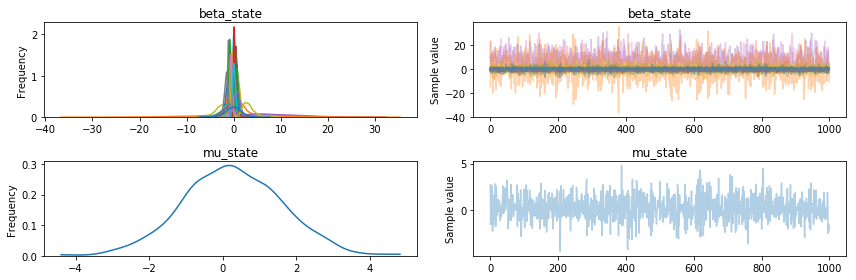

In [336]:
pm.traceplot(trace_state_sd10, varnames_state)

In [587]:
y_obs_foo = np.repeat([0,1,1], len(y_obs) / 3)
sum(y_obs_foo == 1) / len(y_obs)

0.66666666666666663

In [588]:
with pm.Model() as model_state:
    mu_state = pm.Normal('mu_state', mu=0, sd=5)
    beta_state = pm.Normal('beta_state', mu=mu_state, sd=5, 
                           shape=state_count)

    mu = pm.math.dot(vals_with_state[:,6:], beta_state)
            
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    #y = pm.Bernoulli('y', theta, observed=y_obs)
    y = pm.Bernoulli('y', theta, observed=y_obs_foo)

In [589]:
with model_state:
    trace_state = pm.sample(1000, n_init=50000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:18<00:00, 110.38it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x156eacd30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x156fb0438>]], dtype=object)

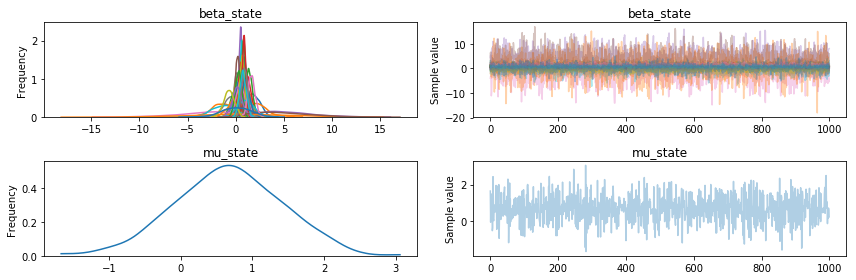

In [590]:
pm.traceplot(trace_state, varnames_state)

Side note that at least w/ this try, cutting the SD from 10 to 5 on the priors, with no changes, sped up the sampling from 27s to 14s. The other things look roughly the same (note that the beta_state plots have different x-axis limits.)

In [591]:
pm.df_summary(trace_state, varnames_state)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
beta_state__0,1.954232,0.630823,0.017701,0.787755,3.156637
beta_state__1,-1.620189,1.135552,0.033938,-3.887440,0.523466
beta_state__2,0.823214,0.325518,0.007768,0.238119,1.496107
beta_state__3,0.759259,0.610822,0.014293,-0.293624,2.058911
beta_state__4,0.517420,0.164460,0.004644,0.185822,0.818126
beta_state__5,0.721199,0.374061,0.009233,-0.011692,1.428307
beta_state__6,0.632685,0.509177,0.012206,-0.460864,1.668476
beta_state__7,-0.582613,0.820783,0.021249,-2.208941,1.053058
beta_state__8,0.217156,0.638424,0.014413,-0.943596,1.547621
beta_state__9,0.623932,0.192825,0.005075,0.259756,0.988489


In [592]:
with pm.Model() as model_state_not_multilevel:
    beta_state = pm.Normal('beta_state', mu=0, sd=5, 
                            shape=state_count)

    mu = pm.math.dot(vals_with_state[:,6:], beta_state)
            
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    #y = pm.Bernoulli('y', theta, observed=y_obs)
    y = pm.Bernoulli('y', theta, observed=y_obs_foo)

In [593]:
with model_state_not_multilevel:
    trace_state_not_multilevel = pm.sample(1000, n_init=50000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:15<00:00, 127.99it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x157860668>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1579a2940>]], dtype=object)

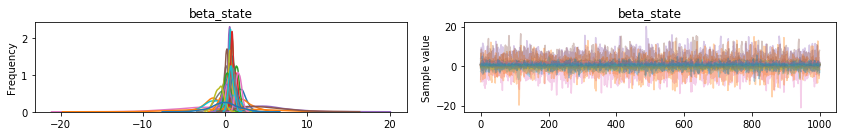

In [594]:
pm.traceplot(trace_state_not_multilevel, varnames_state[:1])

In [595]:
pm.df_summary(trace_state_not_multilevel, varnames_state[:1])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
beta_state__0,1.959649,0.632511,0.018312,0.861654,3.299316
beta_state__1,-1.682540,1.184887,0.031800,-4.341605,0.307187
beta_state__2,0.804783,0.316974,0.008969,0.149200,1.385834
beta_state__3,0.736838,0.625840,0.018066,-0.489074,1.956919
beta_state__4,0.523715,0.157548,0.003287,0.181887,0.793271
beta_state__5,0.716571,0.380912,0.008630,0.038247,1.508086
beta_state__6,0.643487,0.535483,0.013051,-0.383584,1.723620
beta_state__7,-0.588963,0.753876,0.023687,-2.211183,0.759313
beta_state__8,0.181320,0.659718,0.017330,-1.040625,1.463178
beta_state__9,0.622121,0.176465,0.004988,0.295168,0.980219


In [596]:
varnames_state

['beta_state', 'mu_state']

In [597]:
interesting_states_multilevel = pm.df_summary(trace_state, varnames_state).iloc[state_ids]
interesting_states_multilevel

,mean,sd,mc_error,hpd_2.5,hpd_97.5
beta_state__8,0.217156,0.638424,0.014413,-0.943596,1.547621
beta_state__26,-3.311548,3.060854,0.094014,-10.235105,1.667445
beta_state__34,5.590523,2.836366,0.084559,0.758998,11.191549
beta_state__41,0.509896,5.070157,0.128518,-8.718754,10.364409


In [598]:
pm.df_summary(trace_state, ['mu_state'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu_state,0.66756,0.742022,0.020018,-0.688781,2.15112


In [599]:
interesting_states_notmultilevel = pm.df_summary(trace_state_not_multilevel, varnames_state[:1]).iloc[state_ids]
interesting_states_notmultilevel

,mean,sd,mc_error,hpd_2.5,hpd_97.5
beta_state__8,0.181320,0.659718,0.017330,-1.040625,1.463178
beta_state__26,-3.667052,3.202950,0.105596,-9.780037,2.059830
beta_state__34,5.425242,2.784094,0.090828,1.125242,11.341192
beta_state__41,0.110193,4.894338,0.123931,-9.682163,8.996025


In [600]:
sum(y_obs) / len(y_obs)

0.46885245901639344

In [601]:
sum(d_only['q10horse'] == 'Trump/lean Trump') / len(d_only)

0.46885245901639344

In [602]:
print('multilevel, mu_state: ', end="")
print(pm.df_summary(trace_state, ['mu_state']).loc['mu_state']['mean'], 
      standard_logistic(pm.df_summary(trace_state, ['mu_state']).loc['mu_state']['mean']))

print('multilevel, beta_state__41: ', end="")
print(interesting_states_multilevel.loc['beta_state__41']['mean'],
      standard_logistic(interesting_states_multilevel.loc['beta_state__41']['mean']))

print('non-multilevel, beta_state__41: ', end="")
print(interesting_states_notmultilevel.loc['beta_state__41']['mean'],
      standard_logistic(interesting_states_notmultilevel.loc['beta_state__41']['mean']))

multilevel, mu_state: 0.667560255549 0.660956644534
multilevel, beta_state__41: 0.50989610762 0.624782119354
non-multilevel, beta_state__41: 0.110192553266 0.527520297082


Actually, I wasn't doing what I thought I was doing... the not multilevel model is a NOT pooled at all model. I don't know why the value I get for SD, before the logistic, is around WRONG - see next paragraph... it seems like we start with a prior that has a mu of zero and SD of 5, and then we have NO data that ends up informing that for SD... so why would this change?

**UPDATE** to above: I was accidentally pulling state w/ ID 40 (South Carolina) and not ID 41 (South Dakota). When I pull South Dakota and apply the logistic function, then I get a multilevel probability of 0.51 and a non-multilevel probability of 0.49. 

So, does this mean that the non-multilevel model is ok? Is 49% close enough to 50%? Is 50% what we'd expect given no data at all and a prior of 0? (The answer to this second question is yes, I think: when I changed the prior in the non-multilevel model to 5, then the value for beta_state 41 changed to 5.04, from 0.49. It also took 28s to sample vs 14-15s when I don't have this odd value.) And the diff from 50% is somehow for ex perhaps due to MCMC variance? (I think yes: when I ran it again with the same mu of zero, I got a 0.13 value that translates into a probability of 0.53. Yet another run gave me 0.197 and 0.55. So there's variance around 0, I think.) If this is true, the question then is - is this the right question? - **why we're not getting shrinkage to the overall average proportion that voted for Trump, of 0.47** when we have no data?

Above, in the multilevel model, I see the value for SD as pretty close to the value for the mu_state hyper-prior, which is what I'd expect (I think). But why is this value for the hyper prior so consistently different from the overall proportion that voted for Trump? In two runs - one w/ 1k sample and one w/ 10k - I got about 0.14 both times. This is a proportion of 0.53, not 0.47. **Do I have the indicator variable for something, perhaps for the observed data, backwards?** 1-0.53 IS 0.47, after all. 

Here's some data to help answer:
- I ran both models with 1/3 1s and 2/3 0s. For the multilevel model I got 0.223 and 0.218 for the values for mu_state and beta_state 41, which translate to probabilities of 0.227 and 0.217. As expected, the non-multilevel model's beta_state 41 value wasn't affected by the change in the observed data, and in this run it showed 0.201 and 0.551.
- I ran the same models again, w/ no change - i.e., so any difference is entirely due to MCMC variability. This time I got mu_state values that were farther apart from beta_state 41 than I'd previously seen: -1.18/0.235 for mu_state and -0.910/0.287 for beta state 41. The non-multilevel model was 0.170/0.542.
- In more run, -1.23/0.225 for mu_state and -1.067/0.255 for beta state 41. The non-multilevel model was -0.155/0.461.

Then I did some runs with 2/3 1s and 1/3 0s.
- run one:
    - multilevel, mu_state: 0.669528931598 0.661397671083
    - multilevel, beta_state__41: 0.734630885268 0.675820664701
    - non-multilevel, beta_state__41: -0.114127818538 0.471498974517
- run two;:
    - multilevel, mu_state: 0.685943913793 0.665064023604
    - multilevel, beta_state__41: 0.690498888973 0.666077897897
    - non-multilevel, beta_state__41: -0.0414462573059 0.48963991867
- run three:
    - multilevel, mu_state: 0.667560255549 0.660956644534
    - multilevel, beta_state__41: 0.50989610762 0.624782119354
    - non-multilevel, beta_state__41: 0.110192553266 0.527520297082

So, for now, absent more work - which I kind of want to do now, but will defer - as outlined in the next paragraph, my take is that shrinkage is happening, but I'm just not seeing it obviously because the normal variance I get due to MCMC is bigger than what I'd expect to see in shrinkage, because the 'without data and without shrinkage' case is 50% and the actual is only 47%. Two points back this up: a) the normal variance is more than 3%, and b) when I artificially change the input data from 47% to something like 33% or 66% then I _do_ see shrinkage (I'm pretty sure).

**TODO P1** I could wrap up the sample call and then do it ~10 times and output the above states (perhaps starting w/ a filtered DF from df_summary and then adding the logistic call?) and then with a single command check a) many calls w/ each of the two 1/3 and 2/3 splits (including seeing if the odd 20-25% proportions w/ the first stick with many runs), and b) try different params - like diff SDs, perhaps even diff distributions, to see if i can get better results. Fundamentally, when there's no data, the prior will dominate. Am I defining the prior in a way to let this happen?


(Also, if I want to see a comparison of the multilevel model to a model where all of the data is combined, w/o regard for the particular state - i.e., a completely pooled model, then I'm not doing it here. I think I did do something similar above w/ just sex, and I'd want to do it again here (how?).)

# Go back to the sex, race, state model and get proportions for each cell

I could continue to build up the model w/ additional predictors (income, more), but that's an enhancement, not something I _have_ to have for a presentation. 

Instead, I'll cut to the chase and get what I need from the 'multilevel regression' part of MRP: an estimate of the likelihood of voting for both candidates, for each cell, based on a Bayesian logistic regression model that includes shrinkage for the fields (here race and state) that have more than two possibilities (since sharing a hyperprior is only possible when you have at least two variables/coefs - you can't _share_ with just one).

This started w/ the last full model I did above before I started experimenting w/ just state data, since that model looked like it didn't have auto correlation and gave at least plausible state results.

In [610]:
with pm.Model() as model_with_race_and_state_further:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta_sex = pm.Normal('beta_sex', mu=0, sd=10)
    
    mu_race = pm.Normal('mu_race', mu=0, sd=10)
    sigma_race = pm.HalfCauchy('sigma_race', 5)
    beta_race = pm.Normal('beta_race', mu=mu_race, sd=sigma_race, 
                          shape=len(np.unique(d_only['racecmb'])))
    
    mu_state = pm.Normal('mu_state', mu=0, sd=10)
    beta_state = pm.Normal('beta_state', mu=mu_state, sd=10, 
                          shape=state_count)

    mu = alpha + \
         vals_with_state[:,0] * beta_sex + \
         pm.math.dot(vals_with_state[:,1:6], beta_race) + \
         pm.math.dot(vals_with_state[:,6:], beta_state)
            
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    y = pm.Bernoulli('y', theta, observed=y_obs)

In [613]:
with model_with_race_and_state_further:
    trace_with_race_and_state_further = pm.sample(1000, n_init=50000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [15:45<00:00,  1.44it/s]/Users/andrewenfield/miniconda3/envs/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)



In [616]:
varnames_model_with_race_and_state_further = ['alpha', 'beta_sex', 
                                              'mu_race', 'sigma_race', 'beta_race',
                                              'mu_state', 'beta_state']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1690dc438>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x15ed7b908>]], dtype=object)

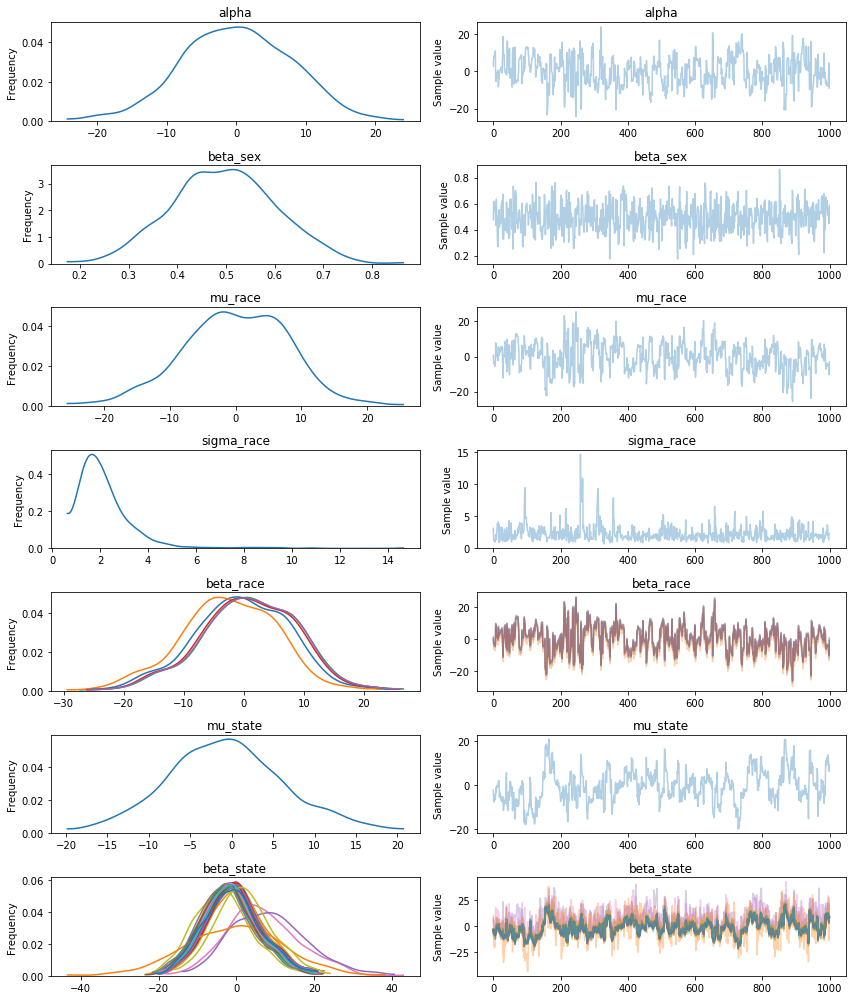

In [617]:
pm.traceplot(trace_with_race_and_state_further, varnames_model_with_race_and_state_further)

In [618]:
pm.df_summary(trace_with_race_and_state_further, varnames_model_with_race_and_state_further)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-0.030703,7.755967,0.486182,-15.163248,14.613962
beta_sex,0.493731,0.105271,0.004132,0.304979,0.703542
mu_race,-0.120716,7.865872,0.520907,-17.203540,13.014497
sigma_race,2.221312,1.265214,0.077152,0.850895,4.398321
beta_race__0,-0.396666,7.982427,0.529143,-17.466993,12.943656
beta_race__1,-2.687959,7.962194,0.528412,-19.921130,10.407473
beta_race__2,1.041168,7.965711,0.528154,-16.135125,14.352164
beta_race__3,0.590222,7.966266,0.528999,-16.310328,14.108456
beta_race__4,0.953067,7.966728,0.528749,-15.999599,14.332894
mu_state,-0.655000,7.183199,0.598448,-14.909077,13.930015


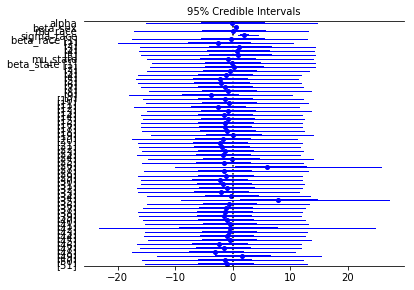

In [619]:
pm.forestplot(trace_with_race_and_state_further, varnames_model_with_race_and_state_further)

In [620]:
with pm.Model() as model_with_race_and_state_further_smaller_sd:
    alpha = pm.Normal('alpha', mu=0, sd=5)
    beta_sex = pm.Normal('beta_sex', mu=0, sd=5)
    
    mu_race = pm.Normal('mu_race', mu=0, sd=5)
    sigma_race = pm.HalfCauchy('sigma_race', 5)
    beta_race = pm.Normal('beta_race', mu=mu_race, sd=sigma_race, 
                          shape=len(np.unique(d_only['racecmb'])))
    
    mu_state = pm.Normal('mu_state', mu=0, sd=5)
    #sigma_state = pm.HalfCauchy('sigma_state', 5)
    beta_state = pm.Normal('beta_state', mu=mu_state, sd=5, 
                          shape=state_count)
    
    mu = alpha + \
         vals_with_state[:,0] * beta_sex + \
         pm.math.dot(vals_with_state[:,1:6], beta_race) + \
         pm.math.dot(vals_with_state[:,6:], beta_state)
            
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    y = pm.Bernoulli('y', theta, observed=y_obs)

In [621]:
with model_with_race_and_state_further_smaller_sd:
    trace_with_race_and_state_further_smaller_sd = pm.sample(1000, n_init=50000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 1999/2000 [09:34<00:00,  1.72it/s]/Users/andrewenfield/miniconda3/envs/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
100%|██████████| 2000/2000 [09:34<00:00,  3.48it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x15c3a18d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x15c89ff28>]], dtype=object)

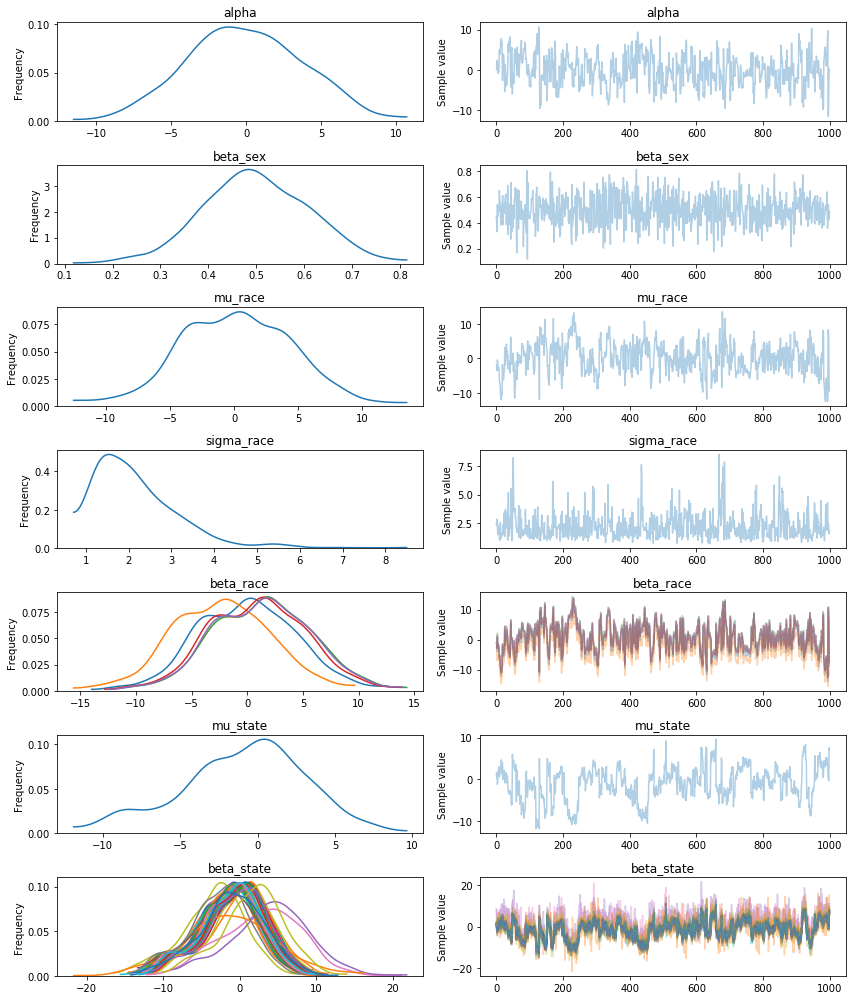

In [622]:
pm.traceplot(trace_with_race_and_state_further_smaller_sd, varnames_model_with_race_and_state_further)

In [623]:
pm.df_summary(trace_with_race_and_state_further_smaller_sd, varnames_model_with_race_and_state_further)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-0.117519,3.815216,0.241730,-6.933191,7.409415
beta_sex,0.498152,0.109756,0.004392,0.301060,0.718817
mu_race,0.211504,4.349947,0.301523,-8.057638,8.817517
sigma_race,2.234504,1.073630,0.054340,0.764151,4.178582
beta_race__0,-0.129115,4.399249,0.313006,-8.368585,8.767963
beta_race__1,-2.426105,4.369476,0.310005,-10.348801,6.871871
beta_race__2,1.330656,4.392935,0.312029,-6.175685,10.805337
beta_race__3,0.858805,4.373488,0.310665,-7.161562,9.711786
beta_race__4,1.233167,4.379554,0.311346,-7.107194,9.831261
mu_state,-0.988334,3.984284,0.332603,-9.934319,5.475118


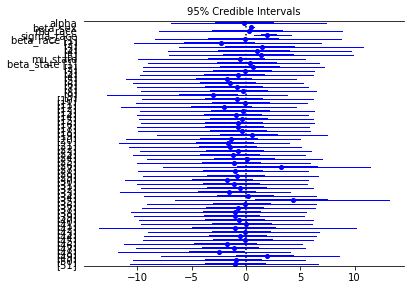

In [624]:
pm.forestplot(trace_with_race_and_state_further_smaller_sd, varnames_model_with_race_and_state_further)

Ok, so it definitely is quicker - 9m vs 15m - and the numbers are different (for ex, the SDs for state are mostly around four instead of around seven something), and the charts look different. It's not clear w/o actually generating predictions if one is better than the other (and even if it was, is that enough to say the sample is better?). 

Fundamentally, I think when we have the relatively small (?) amount of data we have, per state, that the prior saying the possible good values are spread out (to SD 10) vs not so much, does have a pretty big impact on what is plausible. That said, while the SDs and credible intervals are different, at a glance, it looks like the actual mean values are closer, and could even be called 'pretty close'? So, this would argue for the smaller SDs being ok? On the other side, this could be a side effect of most states being closer to 50%? When you look at DC or Montana or North Dakota, the means sometimes actually change a lot. DC is similar, but both of the other states jump - from 2.8 to 6.8 or so, for ex.

Bottom line, I probably would like to try both when I can more easily compare to the actual results - perhaps at the end. For the purposes of the presentation and paper, given that accuracy isn't super important, I could probably go with either (assuming the one I pick doesn't perform so abysmally that it's hard to defend?)

# Generate full set of cell input data

I've played above w/ prediction using a manually created table of 10 rows. Now I want to get the full table of 510 rows - 2 x 5 x 51, for two sexes, five race values, and 51 state values.

In [691]:
all_cells_list = list(itertools.product(np.sort(d_only['sex'].unique()), 
                             np.sort(d_only['racecmb'].unique()),
                             sorted(state_number_to_name.values())))
all_cells_list[:3]

[('Female', 'Asian or Asian-American', 'Alabama'),
 ('Female', 'Asian or Asian-American', 'Alaska'),
 ('Female', 'Asian or Asian-American', 'Arizona')]

In [692]:
len(all_cells_list)

510

In [830]:
all_cells = pd.DataFrame(all_cells_list, columns=['sex','racecmb','state'])
all_cells[:3]

,sex,racecmb,state
0,Female,Asian or Asian-American,Alabama
1,Female,Asian or Asian-American,Alaska
2,Female,Asian or Asian-American,Arizona


In [831]:
# remove sex_Female since we only need one col for sex
all_cells_dummies = pd.get_dummies(all_cells).drop('sex_Female', 1)
all_cells_dummies[:3]

,sex_Male,racecmb_Asian or Asian-American,racecmb_Black or African-American,racecmb_Mixed Race,racecmb_Or some other race,racecmb_White,state_Alabama,state_Alaska,state_Arizona,state_Arkansas,...,state_South Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming
0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# Now try predicting w/ sex, race, state model

Looks like the classify_with_racecmb function should actually work with all, because it's just using the dot product. I'll define it here generally and then use it.

In [714]:
def classify_with_matrix(values_matrix, threshold, trace_data, varnames, add_intercept=False):
    if add_intercept:
        # add a column at the beginning with all ones, to match up w/ something like an alpha param
        values_matrix = np.c_[np.ones(len(values_matrix)), values_matrix]

    mean_vals = pm.df_summary(trace_data, varnames)['mean'].values

    mu = np.dot(values_matrix, mean_vals)

    prob = standard_logistic(mu)
    return prob, prob > threshold

In [715]:
varnames_model_with_race_and_state_further_ = ['alpha', 'beta_sex', 
                                              'mu_race', 'sigma_race', 'beta_race',
                                              'mu_state', 'beta_state']

In [832]:
probs, _ = classify_with_matrix(all_cells_dummies, 0.5, trace_with_race_and_state_further_smaller_sd,
                                ['alpha','beta_sex','beta_race','beta_state'], add_intercept=True)
probs.shape

(510,)

In [833]:
all_cells['trump_prob'] = probs
all_cells.shape

(510, 4)

In [834]:
all_cells[:3]

,sex,racecmb,state,trump_prob
0,Female,Asian or Asian-American,Alabama,0.428666
1,Female,Asian or Asian-American,Alaska,0.502511
2,Female,Asian or Asian-American,Arizona,0.323465


In [724]:
all_cells[all_cells['state'] == 'District of Columbia']

,sex,racecmb,state,trump_prob
8,Female,Asian or Asian-American,District of Columbia,0.019781
59,Female,Black or African-American,District of Columbia,0.002025
110,Female,Mixed Race,District of Columbia,0.079932
161,Female,Or some other race,District of Columbia,0.051411
212,Female,White,District of Columbia,0.073050
263,Male,Asian or Asian-American,District of Columbia,0.032143
314,Male,Black or African-American,District of Columbia,0.003329
365,Male,Mixed Race,District of Columbia,0.125087
416,Male,Or some other race,District of Columbia,0.081888
467,Male,White,District of Columbia,0.114802


In [725]:
all_cells[all_cells['state'] == 'Washington']

,sex,racecmb,state,trump_prob
47,Female,Asian or Asian-American,Washington,0.042171
98,Female,Black or African-American,Washington,0.004408
149,Female,Mixed Race,Washington,0.159337
200,Female,Or some other race,Washington,0.105739
251,Female,White,Washington,0.146708
302,Male,Asian or Asian-American,Washington,0.067560
353,Male,Black or African-American,Washington,0.007233
404,Male,Mixed Race,Washington,0.237756
455,Male,Or some other race,Washington,0.162891
506,Male,White,Washington,0.220542


In [726]:
all_cells[all_cells['state'] == 'New York']

,sex,racecmb,state,trump_prob
32,Female,Asian or Asian-American,New York,0.099022
83,Female,Black or African-American,New York,0.010931
134,Female,Mixed Race,New York,0.321178
185,Female,Or some other race,New York,0.227898
236,Female,White,New York,0.300303
287,Male,Asian or Asian-American,New York,0.153166
338,Male,Black or African-American,New York,0.017863
389,Male,Mixed Race,New York,0.437771
440,Male,Or some other race,New York,0.326939
491,Male,White,New York,0.413940


In [727]:
all_cells[all_cells['state'] == 'Alabama']

,sex,racecmb,state,trump_prob
0,Female,Asian or Asian-American,Alabama,0.428666
51,Female,Black or African-American,Alabama,0.070157
102,Female,Mixed Race,Alabama,0.763592
153,Female,Or some other race,Alabama,0.668326
204,Female,White,Alabama,0.745544
255,Male,Asian or Asian-American,Alabama,0.552520
306,Male,Black or African-American,Alabama,0.110452
357,Male,Mixed Race,Alabama,0.841660
408,Male,Or some other race,Alabama,0.768307
459,Male,White,Alabama,0.828231


In [728]:
all_cells[all_cells['state'] == 'South Dakota']

,sex,racecmb,state,trump_prob
41,Female,Asian or Asian-American,South Dakota,0.200992
92,Female,Black or African-American,South Dakota,0.024672
143,Female,Mixed Race,South Dakota,0.519905
194,Female,Or some other race,South Dakota,0.403191
245,Female,White,South Dakota,0.495544
296,Male,Asian or Asian-American,South Dakota,0.292773
347,Male,Black or African-American,South Dakota,0.039966
398,Male,Mixed Race,South Dakota,0.640565
449,Male,Or some other race,South Dakota,0.526466
500,Male,White,South Dakota,0.617825


In [729]:
all_cells[all_cells['state'] == 'North Dakota']

,sex,racecmb,state,trump_prob
34,Female,Asian or Asian-American,North Dakota,0.978479
85,Female,Black or African-American,North Dakota,0.820536
136,Female,Mixed Race,North Dakota,0.994917
187,Female,Or some other race,North Dakota,0.991877
238,Female,White,North Dakota,0.994399
289,Male,Asian or Asian-American,North Dakota,0.986811
340,Male,Black or African-American,North Dakota,0.882688
391,Male,Mixed Race,North Dakota,0.996905
442,Male,Or some other race,North Dakota,0.995048
493,Male,White,North Dakota,0.996589


In [730]:
all_cells[all_cells['state'] == 'Montana']

,sex,racecmb,state,trump_prob
26,Female,Asian or Asian-American,Montana,0.928232
77,Female,Black or African-American,Montana,0.565337
128,Female,Mixed Race,Montana,0.982357
179,Female,Or some other race,Montana,0.972017
230,Female,White,Montana,0.980585
281,Male,Asian or Asian-American,Montana,0.955126
332,Male,Black or African-American,Montana,0.681571
383,Male,Mixed Race,Montana,0.989204
434,Male,Or some other race,Montana,0.982807
485,Male,White,Montana,0.988112


In [731]:
all_cells[all_cells['state'] == 'Florida']

,sex,racecmb,state,trump_prob
9,Female,Asian or Asian-American,Florida,0.185070
60,Female,Black or African-American,Florida,0.022327
111,Female,Mixed Race,Florida,0.494351
162,Female,Or some other race,Florida,0.378846
213,Female,White,Florida,0.470015
264,Male,Asian or Asian-American,Florida,0.272056
315,Male,Black or African-American,Florida,0.036222
366,Male,Mixed Race,Florida,0.616698
417,Male,Or some other race,Florida,0.500926
468,Male,White,Florida,0.593407


In [732]:
all_cells[all_cells['state'] == 'Pennsylvania']

,sex,racecmb,state,trump_prob
38,Female,Asian or Asian-American,Pennsylvania,0.153422
89,Female,Black or African-American,Pennsylvania,0.017898
140,Female,Mixed Race,Pennsylvania,0.438256
191,Female,Or some other race,Pennsylvania,0.327372
242,Female,White,Pennsylvania,0.414418
293,Male,Asian or Asian-American,Pennsylvania,0.229726
344,Male,Black or African-American,Pennsylvania,0.029118
395,Male,Mixed Race,Pennsylvania,0.562154
446,Male,Or some other race,Pennsylvania,0.444741
497,Male,White,Pennsylvania,0.538032


In [733]:
all_cells[all_cells['state'] == 'Illinois']

,sex,racecmb,state,trump_prob
13,Female,Asian or Asian-American,Illinois,0.163046
64,Female,Black or African-American,Illinois,0.019214
115,Female,Mixed Race,Illinois,0.456122
166,Female,Or some other race,Illinois,0.343482
217,Female,White,Illinois,0.432060
268,Male,Asian or Asian-American,Illinois,0.242764
319,Male,Black or African-American,Illinois,0.031232
370,Male,Mixed Race,Illinois,0.579857
421,Male,Or some other race,Illinois,0.462654
472,Male,White,Illinois,0.555940


In [739]:
all_cells[all_cells['state'] == 'Alabama']

,sex,racecmb,state,trump_prob
0,Female,Asian or Asian-American,Alabama,0.428666
51,Female,Black or African-American,Alabama,0.070157
102,Female,Mixed Race,Alabama,0.763592
153,Female,Or some other race,Alabama,0.668326
204,Female,White,Alabama,0.745544
255,Male,Asian or Asian-American,Alabama,0.552520
306,Male,Black or African-American,Alabama,0.110452
357,Male,Mixed Race,Alabama,0.841660
408,Male,Or some other race,Alabama,0.768307
459,Male,White,Alabama,0.828231


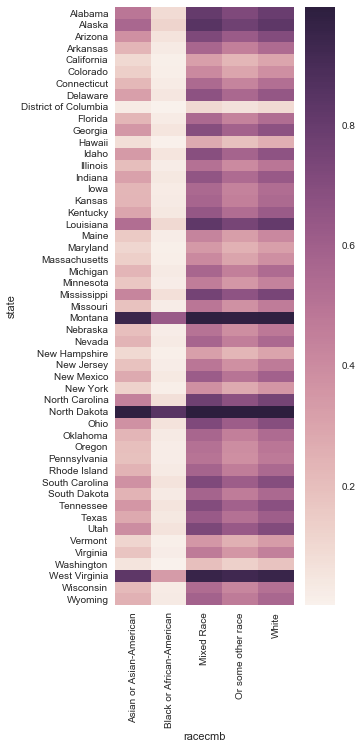

In [751]:
plt.figure(figsize=(4,11))
sns.heatmap(all_cells.pivot_table(columns='racecmb',index='state',values='trump_prob'))

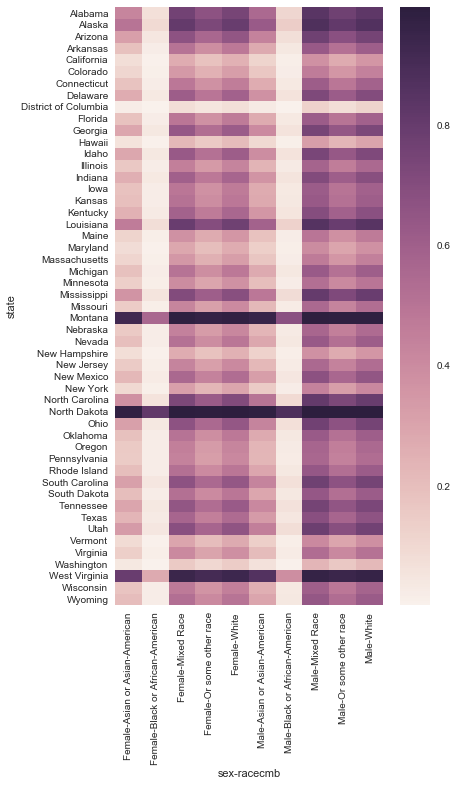

In [749]:
plt.figure(figsize=(6,11))
sns.heatmap(all_cells.pivot_table(columns=['sex','racecmb'],index='state',values='trump_prob'))

# Work with CPS data

In [777]:
d_cps = pd.read_csv('~/OneDrive/Personal/School/Master\'s/DATA 512/Project/cps_00001.csv')
d_cps.shape

(185487, 17)

In [778]:
d_cps.shape

(185487, 17)

In [779]:
d_cps[:5]

,YEAR,SERIAL,HWTSUPP,CPSID,REGION,STATEFIP,STATECENSUS,ASECFLAG,MONTH,PERNUM,CPSIDP,WTSUPP,AGE,SEX,RACE,HISPAN,EDUC99
0,2016,2,1132.05,2.014120e+13,New England Division,Maine,Maine,ASEC,March,1,20141202933701,1132.05,79,Female,White,Not Hispanic,5th-8th grade
1,2016,7,1077.54,2.015120e+13,New England Division,Maine,Maine,ASEC,March,1,20151202935901,1077.54,60,Female,White,Not Hispanic,10th grade
2,2016,7,1077.54,2.015120e+13,New England Division,Maine,Maine,ASEC,March,2,20151202935902,1077.54,59,Male,White,Not Hispanic,"Some college, no degree"
3,2016,8,1151.49,2.016020e+13,New England Division,Maine,Maine,ASEC,March,1,20160202937401,1151.49,69,Male,White,Not Hispanic,"Some college, no degree"
4,2016,9,705.00,2.016010e+13,New England Division,Maine,Maine,ASEC,March,1,20160102910901,705.00,24,Male,White,Not Hispanic,"High school graduate, or GED"


In [780]:
d_cps.groupby(['RACE'])['WTSUPP'].sum().sort_values(ascending=False)

RACE
White                                                    2.458050e+08
Black/Negro                                              4.170345e+07
Asian only                                               1.824928e+07
American Indian/Aleut/Eskimo                             4.299843e+06
White-Black                                              2.769582e+06
White-American Indian                                    2.145419e+06
White-Asian                                              1.374479e+06
Hawaiian/Pacific Islander only                           1.160598e+06
Black-American Indian                                    3.139107e+05
White-Black-American Indian                              2.836355e+05
White-Hawaiian/Pacific Islander                          2.755069e+05
Asian-Hawaiian/Pacific Islander                          1.016896e+05
Black-Asian                                              9.687077e+04
White-Black-Asian                                        6.684736e+04
White-Asian-Haw

The page at https://en.wikipedia.org/wiki/Demography_of_the_United_States#Race_and_ethnicity says that there were 233k people that are white as of 2015, so the 246k number seems at least in the ballpark. The same page says 40k for black, which also matches up w/ the 42k above. 

In [783]:
foo = d_cps[d_cps['RACE'] == 'American Indian-Hawaiian/Pacific Islander']
foo

,YEAR,SERIAL,HWTSUPP,CPSID,REGION,STATEFIP,STATECENSUS,ASECFLAG,MONTH,PERNUM,CPSIDP,WTSUPP,AGE,SEX,RACE,HISPAN,EDUC99
143061,2016,75216,505.08,2.014120e+13,Mountain Division,New Mexico,New Mexico,ASEC,March,1,20141204490301,505.08,37,Male,American Indian-Hawaiian/Pacific Islander,Not Hispanic,Doctorate degree
183059,2016,93033,580.65,2.016030e+13,Pacific Division,Hawaii,Hawaii,ASEC,March,3,20160302042404,292.14,12,Female,American Indian-Hawaiian/Pacific Islander,Not Hispanic,NIU
183060,2016,93033,580.65,2.016030e+13,Pacific Division,Hawaii,Hawaii,ASEC,March,4,20160302042403,397.25,9,Female,American Indian-Hawaiian/Pacific Islander,Not Hispanic,NIU


In [784]:
foo['WTSUPP'].sum()

1194.47

So, I think I need to a) map the CPS values to the values I got from Pew, b) do a single groupby summing the WTSUPP field to get the total per cell, and c) join that data to the proportion data.

A few questions still to think about:
- When/how/do I take into account whether someone's going to vote or not? 

## Mapping CPS values to Pew values

Based on the quick examination of the fields I'm using right now, I think sex and state are actually good to go w/ no further work. For race I'll need to map, as CPS has a lot more values.

In [787]:
d_cps['SEX'].value_counts(dropna=False)

Female    95519
Male      89968
Name: SEX, dtype: int64

In [788]:
d_cps['RACE'].value_counts(dropna=False)

White                                                    142972
Black/Negro                                               22872
Asian only                                                10709
American Indian/Aleut/Eskimo                               3279
White-American Indian                                      1443
White-Black                                                1378
Hawaiian/Pacific Islander only                              965
White-Asian                                                 816
White-Hawaiian/Pacific Islander                             219
Black-American Indian                                       179
Asian-Hawaiian/Pacific Islander                             173
White-Black-American Indian                                 159
White-Asian-Hawaiian/Pacific Islander                       117
Black-Asian                                                  53
White-Black-Asian                                            31
Four or five races, unspecified         

In [793]:
len(d_cps['STATECENSUS'].value_counts(dropna=False))

51

In [796]:
d_cps['STATECENSUS'].value_counts(dropna=False)

California              18254
Texas                   11735
Florida                  8230
New York                 7433
Illinois                 5441
Pennsylvania             4902
Ohio                     4639
Louisiana                4341
North Carolina           4293
Georgia                  4175
New Mexico               4053
New Jersey               3872
Michigan                 3807
Mississippi              3586
Alabama                  3522
Massachusetts            3517
West Virginia            3517
Virginia                 3413
Arkansas                 3404
Montana                  3393
Arizona                  3358
Tennessee                3259
Washington               3195
Hawaii                   3111
Utah                     3080
Indiana                  3070
District of Columbia     2974
Oklahoma                 2913
Idaho                    2898
South Carolina           2864
Oregon                   2639
Wyoming                  2472
Missouri                 2436
Nevada    

The STATEFIP field appears to have the same names and totals, so I'll just use STATECENSUS. (I think the difference might be in how they're coded in the raw CPS data, but by the time I get the data here, and by the time the data is in R too I think, since the package is translating the codes to values, the different codes have already been mapped to the same value.)

In [798]:
len(d_cps['STATEFIP'].value_counts(dropna=False))

51

In [797]:
d_cps['STATEFIP'].value_counts(dropna=False)

California              18254
Texas                   11735
Florida                  8230
New York                 7433
Illinois                 5441
Pennsylvania             4902
Ohio                     4639
Louisiana                4341
North Carolina           4293
Georgia                  4175
New Mexico               4053
New Jersey               3872
Michigan                 3807
Mississippi              3586
Alabama                  3522
Massachusetts            3517
West Virginia            3517
Virginia                 3413
Arkansas                 3404
Montana                  3393
Arizona                  3358
Tennessee                3259
Washington               3195
Hawaii                   3111
Utah                     3080
Indiana                  3070
District of Columbia     2974
Oklahoma                 2913
Idaho                    2898
South Carolina           2864
Oregon                   2639
Wyoming                  2472
Missouri                 2436
Nevada    

In [799]:
d_only['racecmb'].unique()

array(['White', 'Or some other race', 'Mixed Race',
       'Black or African-American', 'Asian or Asian-American'], dtype=object)

In [803]:
map_cps_race_to_pew_racecmb = {
    'White':'White',
    'Black/Negro':'Black or African-American',
    'Asian only':'Asian or Asian-American',
    'American Indian/Aleut/Eskimo':'Or some other race',
    'White-American Indian':'Mixed Race',
    'White-Black':'Mixed Race',
    'Hawaiian/Pacific Islander only':'Or some other race',
    'White-Asian':'Mixed Race',
    'White-Hawaiian/Pacific Islander':'Mixed Race',
    'Black-American Indian':'Mixed Race',
    'Asian-Hawaiian/Pacific Islander':'Mixed Race',
    'White-Black-American Indian':'Mixed Race',
    'White-Asian-Hawaiian/Pacific Islander':'Mixed Race',
    'Black-Asian':'Mixed Race',
    'White-Black-Asian':'Mixed Race',
    'Four or five races, unspecified':'Mixed Race',
    'Black-Hawaiian/Pacific Islander':'Mixed Race',
    'White-American Indian-Asian':'Mixed Race',
    'Two or three races, unspecified':'Mixed Race',
    'American Indian-Asian':'Mixed Race',
    'White-Black-American Indian-Asian':'Mixed Race',
    'White-Black--Hawaiian/Pacific Islander':'Mixed Race',
    'White-American Indian-Asian-Hawaiian/Pacific Islander':'Mixed Race',
    'White-American Indian-Hawaiian/Pacific Islander':'Mixed Race',
    'American Indian-Hawaiian/Pacific Islander':'Mixed Race',
    'Black-American Indian-Asian':'Mixed Race'
}
map_cps_race_to_pew_racecmb

{'American Indian-Asian': 'Mixed Race',
 'American Indian-Hawaiian/Pacific Islander': 'Mixed Race',
 'American Indian/Aleut/Eskimo': 'Or some other race',
 'Asian only': 'Asian or Asian-American',
 'Asian-Hawaiian/Pacific Islander': 'Mixed Race',
 'Black-American Indian': 'Mixed Race',
 'Black-American Indian-Asian': 'Mixed Race',
 'Black-Asian': 'Mixed Race',
 'Black-Hawaiian/Pacific Islander': 'Mixed Race',
 'Black/Negro': 'Black or African-American',
 'Four or five races, unspecified': 'Mixed Race',
 'Hawaiian/Pacific Islander only': 'Or some other race',
 'Two or three races, unspecified': 'Mixed Race',
 'White': 'White',
 'White-American Indian': 'Mixed Race',
 'White-American Indian-Asian': 'Mixed Race',
 'White-American Indian-Asian-Hawaiian/Pacific Islander': 'Mixed Race',
 'White-American Indian-Hawaiian/Pacific Islander': 'Mixed Race',
 'White-Asian': 'Mixed Race',
 'White-Asian-Hawaiian/Pacific Islander': 'Mixed Race',
 'White-Black': 'Mixed Race',
 'White-Black--Hawaiian/Pa

In [804]:
d_cps['mapped_racecmb'] = d_cps['RACE'].map(map_cps_race_to_pew_racecmb)

In [805]:
d_cps['mapped_racecmb'].value_counts(dropna=False)

White                        142972
Black or African-American     22872
Asian or Asian-American       10709
Mixed Race                     4690
Or some other race             4244
Name: mapped_racecmb, dtype: int64

In [816]:
population_by_cell = d_cps.groupby(['SEX','mapped_racecmb','STATECENSUS'], as_index=False)['WTSUPP'].sum()
population_by_cell.shape

(510, 4)

In [817]:
population_by_cell[:2]

,SEX,mapped_racecmb,STATECENSUS,WTSUPP
0,Female,Asian or Asian-American,Alabama,51040.97
1,Female,Asian or Asian-American,Alaska,28853.07


In [847]:
all_cells_with_population = all_cells.merge(population_by_cell, 
                                            left_on=['sex','racecmb','state'], 
                                            right_on=['SEX','mapped_racecmb','STATECENSUS'],
                                            validate='1:1')[['sex','racecmb','state','trump_prob','WTSUPP']]
all_cells_with_population.rename(columns={'WTSUPP':'population'}, inplace=True)
all_cells_with_population[:3]

,sex,racecmb,state,trump_prob,population
0,Female,Asian or Asian-American,Alabama,0.428666,51040.97
1,Female,Asian or Asian-American,Alaska,0.502511,28853.07
2,Female,Asian or Asian-American,Arizona,0.323465,124310.67


In [848]:
# confirm that the totals are the same in both our cell data and in the CPS data
round(all_cells_with_population['population'].sum()), round(d_cps['WTSUPP'].sum())

(318868490.0, 318868490.0)

In [869]:
all_cells_with_results = all_cells_with_population.copy()
all_cells_with_results['votes_clinton'] = np.round(all_cells_with_results['population'] * (1-all_cells_with_results['trump_prob']), 1).astype('int')
all_cells_with_results['votes_trump'] = np.round(all_cells_with_results['population'] * all_cells_with_results['trump_prob'], 1).astype('int')
# all_cells_with_results['votes_clinton'] = np.round(all_cells_with_results.apply(
#     lambda r: r['population'] * (1-r['trump_prob']), 1)).astype('int')
# all_cells_with_results['votes_trump'] = np.round(all_cells_with_results.apply(
#     lambda r: r['population'] * r['trump_prob'], 1)).astype('int')
all_cells_with_results[:3]

,sex,racecmb,state,trump_prob,population,votes_clinton,votes_trump
0,Female,Asian or Asian-American,Alabama,0.428666,51040.97,29161,21880
1,Female,Asian or Asian-American,Alaska,0.502511,28853.07,14354,14499
2,Female,Asian or Asian-American,Arizona,0.323465,124310.67,84100,40210


## And, now, what do we predict

In [1003]:
all_votes_count = all_cells_with_results['votes_clinton'].sum() + all_cells_with_results['votes_trump'].sum()
all_votes_count

318868016

In [1004]:
all_cells_with_results['votes_clinton'].sum(), all_cells_with_results['votes_trump'].sum()

(180724811, 138143205)

In [1005]:
all_cells_with_results['votes_clinton'].sum() / all_votes_count, all_cells_with_results['votes_trump'].sum()  / all_votes_count

(0.56676995475143543, 0.43323004524856451)

# What does the Pew poll say?

In [881]:
d_only['weight'].sum()

4904.5

In [886]:
d_only.groupby(['q10horseGP'])['weight'].sum()

q10horseGP
Clinton/lean Clinton    2628.352941
Trump/lean Trump        2276.147059
Name: weight, dtype: float64

In [888]:
d_only[d_only['q10horseGP'] == 'Clinton/lean Clinton']['weight'].sum() / d_only['weight'].sum(), \
d_only[d_only['q10horseGP'] == 'Trump/lean Trump']['weight'].sum() / d_only['weight'].sum()

(0.53590640048454907, 0.46409359951545098)

# Experiment w/ additional CPS extract that includes some level of voting data

In [897]:
d_cps_voting = pd.read_csv('~/OneDrive/Personal/School/Master\'s/DATA 512/Project/cps_00004.csv')
d_cps_voting.shape

(131389, 16)

In [898]:
d_cps_voting[:3]

,YEAR,SERIAL,HWTFINL,CPSID,STATEFIP,MONTH,PERNUM,CPSIDP,WTFINL,AGE,SEX,RACE,HISPAN,EDUC99,VOTED,VOREG
0,2016,1,1519.4506,2.016100e+13,Alabama,November,1,20161000000101,1878.9962,70,Male,White,Not Hispanic,"Associate degree, academic program",Voted,Not in universe
1,2016,1,1519.4506,2.016100e+13,Alabama,November,2,20161000000102,1519.4506,63,Female,White,Not Hispanic,"Some college, no degree",Did not vote,Did not register
2,2016,2,1674.5088,2.016110e+13,Alabama,November,1,20161100000201,1674.5088,59,Male,Black/Negro,Not Hispanic,"Some college, no degree",Did not vote,Registered


In [899]:
d_cps_voting['SEX'].value_counts(dropna=False)

Female    67709
Male      63680
Name: SEX, dtype: int64

In [900]:
d_cps_voting['RACE'].value_counts(dropna=False)

White                                                    104857
Black/Negro                                               14055
Asian only                                                 6972
American Indian/Aleut/Eskimo                               1990
White-American Indian                                       866
White-Black                                                 811
Hawaiian/Pacific Islander only                              614
White-Asian                                                 526
White-Hawaiian/Pacific Islander                             143
Black-American Indian                                       127
White-Black-American Indian                                 115
Asian-Hawaiian/Pacific Islander                              89
White-Asian-Hawaiian/Pacific Islander                        78
Black-Asian                                                  54
Black-Hawaiian/Pacific Islander                              22
American Indian-Asian                   

In [902]:
len(d_cps_voting['STATEFIP'].value_counts(dropna=False))

51

In [901]:
d_cps_voting['STATEFIP'].value_counts(dropna=False)

California              11200
Texas                    7371
Florida                  5777
New York                 5119
Illinois                 3847
Pennsylvania             3711
Ohio                     3454
North Carolina           3037
Michigan                 2937
Louisiana                2896
West Virginia            2831
Georgia                  2799
Massachusetts            2711
Alabama                  2651
New Jersey               2647
Montana                  2626
Virginia                 2487
Mississippi              2460
New Mexico               2430
Tennessee                2410
Arkansas                 2342
Washington               2283
Utah                     2239
Idaho                    2195
Arizona                  2145
Indiana                  2110
District of Columbia     2094
Hawaii                   2059
Oregon                   2027
North Dakota             2021
South Carolina           2002
Oklahoma                 1883
Wyoming                  1872
Missouri  

In [903]:
d_cps_voting['VOTED'].value_counts(dropna=False)

Voted              58533
Not in universe    37595
Did not vote       22238
No Response         9979
Refused             1573
Don't know          1471
Name: VOTED, dtype: int64

In [904]:
d_cps_voting['mapped_racecmb'] = d_cps_voting['RACE'].map(map_cps_race_to_pew_racecmb)

In [905]:
d_cps_voting['mapped_racecmb'].value_counts(dropna=False)

White                        104857
Black or African-American     14055
Asian or Asian-American        6972
Mixed Race                     2901
Or some other race             2604
Name: mapped_racecmb, dtype: int64

In [907]:
d_cps_voting_population_by_cell = d_cps_voting.groupby(['SEX','mapped_racecmb','STATEFIP'], as_index=False)['WTFINL'].sum()
d_cps_voting_population_by_cell.shape

(508, 4)

Hmm... that should be 2 x 5 x 51 = 510. Which states don't have all one row for each cell?

In [913]:
(d_cps_voting_population_by_cell['STATEFIP'].unique())[d_cps_voting_population_by_cell.groupby('STATEFIP').size() < 10]

array(['Maine', 'Vermont'], dtype=object)

So, Maine is missing females of 'Or some other race'.

In [915]:
d_cps_voting_population_by_cell[d_cps_voting_population_by_cell['STATEFIP'] == 'Maine']

,SEX,mapped_racecmb,STATEFIP,WTFINL
19,Female,Asian or Asian-American,Maine,9754.6069
70,Female,Black or African-American,Maine,4462.1727
121,Female,Mixed Race,Maine,13686.0606
222,Female,White,Maine,644054.1601
273,Male,Asian or Asian-American,Maine,5334.7327
324,Male,Black or African-American,Maine,14303.7411
375,Male,Mixed Race,Maine,20999.6773
426,Male,Or some other race,Maine,5108.2904
476,Male,White,Maine,598546.5575


And Vermont is missing males of 'Or some other race'.

In [916]:
d_cps_voting_population_by_cell[d_cps_voting_population_by_cell['STATEFIP'] == 'Vermont']

,SEX,mapped_racecmb,STATEFIP,WTFINL
45,Female,Asian or Asian-American,Vermont,7194.2980
96,Female,Black or African-American,Vermont,3659.6508
147,Female,Mixed Race,Vermont,7383.7707
197,Female,Or some other race,Vermont,3078.2986
248,Female,White,Vermont,292484.9831
299,Male,Asian or Asian-American,Vermont,8141.2312
350,Male,Black or African-American,Vermont,4593.6401
401,Male,Mixed Race,Vermont,8969.2326
502,Male,White,Vermont,283089.8951


In [931]:
d_cps_voted_population_by_cell = d_cps_voting[d_cps_voting['VOTED'] == 'Voted'].groupby(['SEX','mapped_racecmb','STATEFIP'], as_index=False)['WTFINL'].sum()
d_cps_voted_population_by_cell.shape

(490, 4)

In [932]:
d_cps_voted_population_by_cell[:3]

,SEX,mapped_racecmb,STATEFIP,WTFINL
0,Female,Asian or Asian-American,Alabama,1822.7216
1,Female,Asian or Asian-American,Alaska,4588.3356
2,Female,Asian or Asian-American,Arizona,31510.3939


In [933]:
d_cps_didnotvote_population_by_cell = d_cps_voting[d_cps_voting['VOTED'] == 'Did not vote'].groupby(['SEX','mapped_racecmb','STATEFIP'], as_index=False)['WTFINL'].sum()
d_cps_didnotvote_population_by_cell.shape

(475, 4)

In [934]:
d_cps_didnotvote_population_by_cell[:3]

,SEX,mapped_racecmb,STATEFIP,WTFINL
0,Female,Asian or Asian-American,Alabama,3167.1616
1,Female,Asian or Asian-American,Alaska,3133.0862
2,Female,Asian or Asian-American,Arizona,12192.8025


In [938]:
(d_cps_voted_population_by_cell.set_index(['SEX','mapped_racecmb','STATEFIP']) + \
d_cps_didnotvote_population_by_cell.set_index(['SEX','mapped_racecmb','STATEFIP']))

WTFINL
SEX    mapped_racecmb          STATEFIP                          
Female Asian or Asian-American Alabama               4.989883e+03
                               Alaska                7.721422e+03
                               Arizona               4.370320e+04
                               Arkansas                       NaN
                               California            1.532221e+06
                               Colorado              3.871649e+04
                               Connecticut           2.937512e+04
                               Delaware              1.154580e+04
                               District of Columbia  8.611764e+03
                               Florida               1.310046e+05

In [961]:
# i was thinking about adding rows w/ voted and not voted counts, decided not to because it seems to require
# multiple group bys? i'll stay w/ the single function below
# d_cps_voted_prop = d_cps_voting.copy()
# d_cps_voted_prop['voted'] = d_cps_voting[d_cps_voting['VOTED'] == 'Voted']['WTFINL'].sum()
# d_cps_voted_prop['did_not_vote'] = d_cps_voting[d_cps_voting['VOTED'] == 'Did not vote']['WTFINL'].sum()
# d_cps_voted_prop['voted_prop'] = d_cps_voted_prop['voted'] / (d_cps_voted_prop['voted'] + d_cps_voted_prop['did_not_vote'])

In [970]:
def get_voted_proportion(g):
    voted_count = g[g['VOTED'] == 'Voted']['WTFINL'].sum()
    if np.isnan(voted_count): # if there are no vote rows, then we had zero (don't think there's a way to do this via a built-in function)
        voted_count = 0
    
    didnotvote_count = g[g['VOTED'] == 'Did not vote']['WTFINL'].sum()
    if np.isnan(didnotvote_count): 
        didnotvote_count = 0

    total_count = voted_count + didnotvote_count
    
    if total_count != 0:
        return voted_count / (voted_count + didnotvote_count)
    else:
        return np.nan


# have to use reset_index instead of as_index=False because the latter isn't working w/ .apply
d_cps_voted_proportion = d_cps_voting.groupby(['SEX','mapped_racecmb','STATEFIP']).apply(get_voted_proportion).reset_index()
d_cps_voted_proportion.rename(columns={0:'voted_prop','SEX':'sex','mapped_racecmb':'racecmb','STATEFIP':'state'}, inplace=True)
d_cps_voted_proportion[:10]

,sex,racecmb,state,voted_prop
0,Female,Asian or Asian-American,Alabama,0.365283
1,Female,Asian or Asian-American,Alaska,0.594235
2,Female,Asian or Asian-American,Arizona,0.721009
3,Female,Asian or Asian-American,Arkansas,1.000000
4,Female,Asian or Asian-American,California,0.617409
5,Female,Asian or Asian-American,Colorado,0.432271
6,Female,Asian or Asian-American,Connecticut,0.343895
7,Female,Asian or Asian-American,Delaware,0.662079
8,Female,Asian or Asian-American,District of Columbia,0.754159
9,Female,Asian or Asian-American,Florida,0.625802


# Now use voted proportion to again predict results

In [971]:
all_cells_with_results[:3]

,sex,racecmb,state,trump_prob,population,votes_clinton,votes_trump
0,Female,Asian or Asian-American,Alabama,0.428666,51040.97,29161,21880
1,Female,Asian or Asian-American,Alaska,0.502511,28853.07,14354,14499
2,Female,Asian or Asian-American,Arizona,0.323465,124310.67,84100,40210


In [972]:
all_cells_with_results_and_voted_prop = all_cells_with_results.merge(d_cps_voted_proportion, 
                on=['sex','racecmb','state'], how='left')
all_cells_with_results_and_voted_prop.shape

(510, 8)

In [973]:
all_cells_with_results_and_voted_prop[:5]

,sex,racecmb,state,trump_prob,population,votes_clinton,votes_trump,voted_prop
0,Female,Asian or Asian-American,Alabama,0.428666,51040.97,29161,21880,0.365283
1,Female,Asian or Asian-American,Alaska,0.502511,28853.07,14354,14499,0.594235
2,Female,Asian or Asian-American,Arizona,0.323465,124310.67,84100,40210,0.721009
3,Female,Asian or Asian-American,Arkansas,0.192313,24256.01,19591,4665,1.000000
4,Female,Asian or Asian-American,California,0.078111,3196447.65,2946770,249677,0.617409


In [974]:
all_cells_with_results_and_voted_prop[all_cells_with_results_and_voted_prop['voted_prop'].isnull()]

,sex,racecmb,state,trump_prob,population,votes_clinton,votes_trump,voted_prop
77,Female,Black or African-American,Montana,0.565337,1854.97,806,1049,NaN
156,Female,Or some other race,Arkansas,0.390043,12811.35,7814,4997,NaN
172,Female,Or some other race,Maine,0.272569,3193.92,2323,871,NaN
414,Male,Or some other race,Connecticut,0.494180,21768.17,11011,10757,NaN
425,Male,Or some other race,Kentucky,0.593640,7706.21,3131,4575,NaN
429,Male,Or some other race,Massachusetts,0.355779,6490.19,4181,2309,NaN
453,Male,Or some other race,Vermont,0.300254,251.33,176,75,NaN


In [975]:
all_cells_with_results_and_voted_prop[all_cells_with_results_and_voted_prop['voted_prop'] == 0]

,sex,racecmb,state,trump_prob,population,votes_clinton,votes_trump,voted_prop
17,Female,Asian or Asian-American,Kentucky,0.248424,29823.16,22414,7409,0.0
41,Female,Asian or Asian-American,South Dakota,0.200992,2835.49,2266,570,0.0
195,Female,Or some other race,Tennessee,0.536317,11282.02,5231,6051,0.0
296,Male,Asian or Asian-American,South Dakota,0.292773,2550.15,1804,747,0.0
406,Male,Mixed Race,Wisconsin,0.601423,54583.75,21756,32828,0.0
415,Male,Or some other race,Delaware,0.619371,2430.41,925,1505,0.0
428,Male,Or some other race,Maryland,0.294378,44493.82,31396,13098,0.0
432,Male,Or some other race,Mississippi,0.718555,9368.65,2637,6732,0.0
433,Male,Or some other race,Missouri,0.434148,15416.71,8724,6693,0.0
438,Male,Or some other race,New Jersey,0.439753,24373.40,13655,10718,0.0


In [976]:
all_cells_with_results_and_voted_prop[all_cells_with_results_and_voted_prop['voted_prop'] == 1]

,sex,racecmb,state,trump_prob,population,votes_clinton,votes_trump,voted_prop
3,Female,Asian or Asian-American,Arkansas,0.192313,24256.01,19591,4665,1.0
45,Female,Asian or Asian-American,Vermont,0.088494,4279.85,3901,379,1.0
56,Female,Black or African-American,Colorado,0.012284,113632.83,112237,1396,1.0
70,Female,Black or African-American,Maine,0.013836,5114.55,5044,71,1.0
80,Female,Black or African-American,New Hampshire,0.008494,10371.93,10284,88,1.0
108,Female,Mixed Race,Connecticut,0.487607,24126.05,12362,11764,1.0
132,Female,Mixed Race,New Jersey,0.433284,71658.06,40610,31048,1.0
142,Female,Mixed Race,South Carolina,0.667857,33683.63,11188,22496,1.0
152,Female,Mixed Race,Wyoming,0.525153,6408.34,3043,3365,1.0
160,Female,Or some other race,Delaware,0.497181,1542.11,775,767,1.0


In [967]:
all_cells_with_results_and_voted_prop[all_cells_with_results_and_voted_prop['state'] == 'Vermont']

,sex,racecmb,state,trump_prob,population,votes_clinton,votes_trump,voted_prop
45,Female,Asian or Asian-American,Vermont,0.088494,4279.85,3901,379,1.000000
96,Female,Black or African-American,Vermont,0.009669,4460.20,4417,43,0.448424
147,Female,Mixed Race,Vermont,0.294758,5358.75,3779,1580,0.724910
198,Female,Or some other race,Vermont,0.206814,312.58,248,65,0.694279
249,Female,White,Vermont,0.274905,299686.03,217301,82385,0.778293
300,Male,Asian or Asian-American,Vermont,0.137762,3063.43,2641,422,1.000000
351,Male,Black or African-American,Vermont,0.015813,3355.54,3302,53,0.692299
402,Male,Mixed Race,Vermont,0.407518,5990.85,3549,2441,0.810365
453,Male,Or some other race,Vermont,0.300254,251.33,176,75,NaN
504,Male,White,Vermont,0.384208,282968.62,174250,108719,0.718767


## Impute/guess at some proportions where we don't have data

The Nov 2016 monthly CPS data doesn't have voted data for every single one of the 510 cells. For two - noted above - there's no data at all/no rows at all for a particular combination, and for more there's at least some rows but there are no voted/did not vote rows for that cell. In either case, we have a nan, since we can't say anything at all about that cell. (There are also some cells where all of the rows are either vote or did not vote, and we've - for better or worse - already marked these as 100% or 0%, respectively.)

Also, I checked a few of the cells and the number of actual votes for the cells are small, so we likely won't change our results in ways we'd notice. 

For ease of implementation, we'll just set these values to the average voted proportion (overall - we could do it from common cells, but won't bother since the number of affected votes is so small).

In [984]:
voted_count = d_cps_voting[d_cps_voting['VOTED'] == 'Voted']['WTFINL'].sum()
did_not_vote_count = d_cps_voting[d_cps_voting['VOTED'] == 'Did not vote']['WTFINL'].sum()
overall_prop_voted = voted_count / (voted_count + did_not_vote_count)
overall_prop_voted

0.71859397336959685

In [986]:
all_cells_with_results_and_voted_prop[all_cells_with_results_and_voted_prop['voted_prop'].isnull()]

,sex,racecmb,state,trump_prob,population,votes_clinton,votes_trump,voted_prop
77,Female,Black or African-American,Montana,0.565337,1854.97,806,1049,NaN
156,Female,Or some other race,Arkansas,0.390043,12811.35,7814,4997,NaN
172,Female,Or some other race,Maine,0.272569,3193.92,2323,871,NaN
414,Male,Or some other race,Connecticut,0.494180,21768.17,11011,10757,NaN
425,Male,Or some other race,Kentucky,0.593640,7706.21,3131,4575,NaN
429,Male,Or some other race,Massachusetts,0.355779,6490.19,4181,2309,NaN
453,Male,Or some other race,Vermont,0.300254,251.33,176,75,NaN


In [988]:
all_cells_with_results_and_voted_prop['voted_prop'].fillna(overall_prop_voted, inplace=True)

In [990]:
all_cells_with_results_and_voted_prop[all_cells_with_results_and_voted_prop['voted_prop'].isnull()]

,sex,racecmb,state,trump_prob,population,votes_clinton,votes_trump,voted_prop


In [989]:
all_cells_with_results_and_voted_prop[all_cells_with_results_and_voted_prop['voted_prop'] == overall_prop_voted]

,sex,racecmb,state,trump_prob,population,votes_clinton,votes_trump,voted_prop
77,Female,Black or African-American,Montana,0.565337,1854.97,806,1049,0.718594
156,Female,Or some other race,Arkansas,0.390043,12811.35,7814,4997,0.718594
172,Female,Or some other race,Maine,0.272569,3193.92,2323,871,0.718594
414,Male,Or some other race,Connecticut,0.494180,21768.17,11011,10757,0.718594
425,Male,Or some other race,Kentucky,0.593640,7706.21,3131,4575,0.718594
429,Male,Or some other race,Massachusetts,0.355779,6490.19,4181,2309,0.718594
453,Male,Or some other race,Vermont,0.300254,251.33,176,75,0.718594


In [1001]:
all_cells_with_results_and_more_voted_data = all_cells_with_results_and_voted_prop.copy()
all_cells_with_results_and_more_voted_data['est_population_voted'] = all_cells_with_results_and_more_voted_data['population'] * \
                                                            all_cells_with_results_and_more_voted_data['voted_prop']
all_cells_with_results_and_more_voted_data['votes_clinton_adj'] = np.round(all_cells_with_results_and_more_voted_data['est_population_voted'] * \
                                                            (1 - all_cells_with_results_and_more_voted_data['trump_prob'])).astype(int)
all_cells_with_results_and_more_voted_data['votes_trump_adj'] = np.round(all_cells_with_results_and_more_voted_data['est_population_voted'] * \
                                                            all_cells_with_results_and_more_voted_data['trump_prob']).astype(int)

all_cells_with_results_and_more_voted_data[:3]

,sex,racecmb,state,trump_prob,population,votes_clinton,votes_trump,voted_prop,est_population_voted,votes_clinton_adj,votes_trump_adj
0,Female,Asian or Asian-American,Alabama,0.428666,51040.97,29161,21880,0.365283,18644.420075,10652,7992
1,Female,Asian or Asian-American,Alaska,0.502511,28853.07,14354,14499,0.594235,17145.491035,8530,8616
2,Female,Asian or Asian-American,Arizona,0.323465,124310.67,84100,40210,0.721009,89629.100394,60637,28992


# What's the prediction based on counts adjusted for likelihood to vote?

In [1007]:
all_votes_adj_count = all_cells_with_results_and_more_voted_data['votes_clinton_adj'].sum() + \
                      all_cells_with_results_and_more_voted_data['votes_trump_adj'].sum()
all_votes_adj_count

227710338

In [1008]:
all_cells_with_results_and_more_voted_data['votes_clinton_adj'].sum(), \
all_cells_with_results_and_more_voted_data['votes_trump_adj'].sum()

(129329055, 98381283)

In [1010]:
all_cells_with_results_and_more_voted_data['votes_clinton_adj'].sum() / all_votes_adj_count, \
all_cells_with_results_and_more_voted_data['votes_trump_adj'].sum()  / all_votes_adj_count

(0.5679542533549794, 0.43204574664502055)

This proportion is dismayingly close to the original prediction - here 0.568 vs 0.567, even though the number of votes is so much smaller and, from an eyeball perspectie I thought that certain cells that I know have diff props for voting one or the other (for ex, depending on race) appeared to have a different likelihood to have voted. It's still different from the Pew prediction. If I did get this right, at least I tried it and showed that this alone isn't the cause of the difference.

**TODO** First off, I absolutely need to sanity check the above, especially the end (when I was most tired), and make sure everything holds up and is consistent. Perhaps I made obvious mistakes.

# List of obvious features we could add

    age - 'age'
    density - 'final density code after zip/fips merges'
    scregion - 'Census region - sample'
    income - 'INCOME Last year, that is in 2015, what was your total family income from all sources, before taxes? Just stop me when I get to the right category. [READ]'
    EDUC2 What is the highest level of school you have completed or the highest degree you have received? [DO NOT READ] [INTERVIEWER NOTE: Enter code 3-HS grad if R completed training that did NOT count toward a degree]
    